## 기본 데이터 전처리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tqdm import tqdm

In [2]:
train = pd.read_csv('/kaggle/input/ml-bootcamp/train.csv')

In [3]:
# id 열 삭제
train = train.drop(['id'], axis = 1)

In [4]:
# gender, vehicle_age, vehicle_damage 데이터 타입 변경 -> 라벨인코더로 통일
label_encoder = LabelEncoder()
cat=['Gender', 'Vehicle_Age', 'Vehicle_Damage']
for column in cat:
    train[column] = label_encoder.fit_transform(train[column])

In [5]:
# Age 범주형 변경

# 구간 설정
bins = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, float('inf')]

# 각 구간에 대한 라벨 설정
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

# Age 열을 범주형 변수로 변환
train['AgeGroup'] = pd.cut(train['Age'], bins=bins, labels=labels, right=False)

In [6]:
# Age 열 삭제
train = train.drop(['Age'], axis = 1)

## 이상치 데이터 제거

In [7]:
# IQR을 이용하여 이상치 제거
Q1 = train['Annual_Premium'].quantile(0.25)
Q3 = train['Annual_Premium'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치가 있는 행 제거
deleted_train = train[(train['Annual_Premium'] >= lower_bound) & (train['Annual_Premium'] <= upper_bound)]

deleted_train.shape

(9127525, 11)

In [8]:
# min_max_scaler
numerical = ['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
scaler = MinMaxScaler()
deleted_train[numerical] = scaler.fit_transform(deleted_train[numerical])
deleted_train.head()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,AgeGroup
1,1,1,0.538462,0,2,1,0.968248,0.154321,0.961938,1,4
2,0,1,0.269231,1,1,0,0.600141,0.932099,0.844291,0,1
4,0,1,0.288462,1,0,0,0.492679,0.932099,0.982699,0,3
5,0,1,0.903846,1,1,0,0.425631,0.932099,0.647059,0,2
6,1,1,0.865385,1,1,0,0.407603,0.932099,0.622837,0,0


In [27]:
# deleted_train.to_csv('modified_train.csv', index = False)

In [9]:
# 데이터 샘플 수가 많아 시간 소요가 커 20%만 활용
_, sample_df = train_test_split(deleted_train, test_size = 0.2, stratify = deleted_train['Response'], random_state = 42)

In [10]:
df = sample_df.reset_index()
df = df.drop(['index'], axis = 1)
df.head() 

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,AgeGroup
0,0,1,0.557692,1,1,0,0.601270,0.932099,0.415225,0,1
1,0,1,0.538462,0,0,1,0.704075,0.018519,0.162630,1,4
2,0,1,0.403846,1,1,0,0.380614,0.932099,0.747405,0,1
3,0,1,0.961538,1,1,0,0.629617,0.932099,0.432526,0,0
4,0,1,0.807692,0,1,0,0.712101,0.932099,0.117647,0,0


In [11]:
df.shape

(1825505, 11)

In [12]:
# X, y 데이터
X = df.drop('Response', axis = 1)
y = df['Response']

In [13]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# 데이터 표준화 (minmaxscaler)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 모델링

### 1. Gradient Boosting Tree

In [16]:
gb_model = GradientBoostingClassifier(random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    gb_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_gb = gb_model.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_score_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)
print(f"GBT ROC AUC: {roc_auc_gb:.4f}") 6117

Training Progress: 100%|██████████| 21/21 [33:29<00:00, 95.69s/it] 


GBT ROC AUC: 0.8715


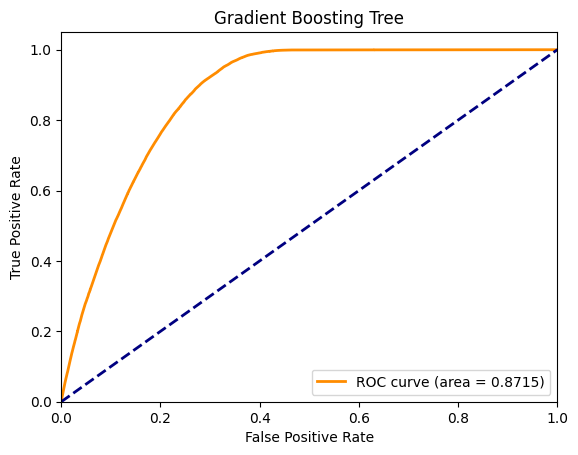

In [17]:
# 시각화
plt.figure()
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc_gb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting Tree')
plt.legend(loc="lower right")
plt.show()

### 2. XGBoost

In [21]:
# XGBoost
xgb_model = XGBClassifier(random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="XGBoost Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    xgb_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_xgb = xgb_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
print(f"XGBoost ROC AUC: {roc_auc_xgb:.4f}")

XGBoost Training Progress: 100%|██████████| 21/21 [01:16<00:00,  3.66s/it]


XGBoost ROC AUC: 0.8821


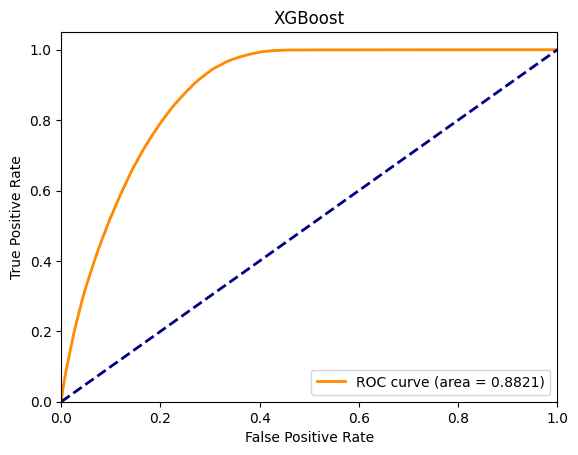

In [24]:
# 시각화
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost')
plt.legend(loc="lower right")
plt.show()

### 3. CatBoost

In [25]:
# CatBoost
cat_model = CatBoostClassifier(random_state=42, verbose=0)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="CatBoost Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    cat_model.fit(X_train[:end], y_train[:end])

y_score_cat = cat_model.predict_proba(X_test)[:, 1]
fpr_cat, tpr_cat, _ = roc_curve(y_test, y_score_cat)
roc_auc_cat = auc(fpr_cat, tpr_cat)
print(f"CatBoost ROC AUC: {roc_auc_cat:.4f}")

CatBoost Training Progress: 100%|██████████| 21/21 [31:25<00:00, 89.76s/it] 


CatBoost ROC AUC: 0.8844


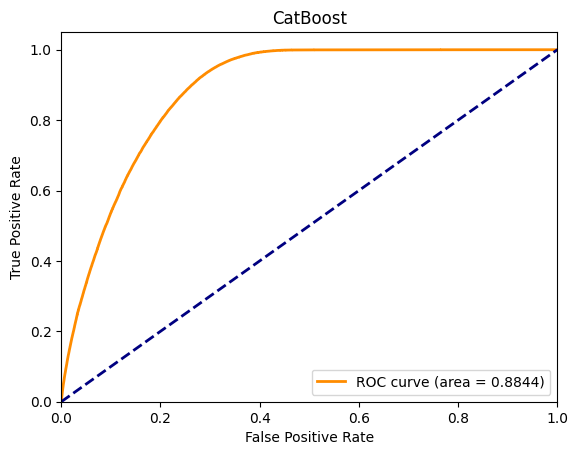

In [26]:
# 시각화
plt.figure()
plt.plot(fpr_cat, tpr_cat, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc_cat)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CatBoost')
plt.legend(loc="lower right")
plt.show()

### 4. LightGBM

In [22]:
lgb_model = LGBMClassifier(random_state=42)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="LightGBM Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    lgb_model.fit(X_train[:end], y_train[:end])

y_score_lgb = lgb_model.predict_proba(X_test)[:, 1]
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_score_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)
print(f"LightGBM ROC AUC: {roc_auc_lgb:.4f}")

LightGBM Training Progress:   0%|          | 0/21 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 8781, number of negative: 64239
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 73020, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120255 -> initscore=-1.990020
[LightGBM] [Info] Start training from score -1.990020


LightGBM Training Progress:   5%|▍         | 1/21 [00:00<00:11,  1.71it/s]

[LightGBM] [Info] Number of positive: 17631, number of negative: 128409
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 146040, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120727 -> initscore=-1.985562
[LightGBM] [Info] Start training from score -1.985562


LightGBM Training Progress:  10%|▉         | 2/21 [00:01<00:16,  1.16it/s]

[LightGBM] [Info] Number of positive: 26490, number of negative: 192570
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 677
[LightGBM] [Info] Number of data points in the train set: 219060, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120926 -> initscore=-1.983692
[LightGBM] [Info] Start training from score -1.983692


LightGBM Training Progress:  14%|█▍        | 3/21 [00:03<00:21,  1.17s/it]

[LightGBM] [Info] Number of positive: 35410, number of negative: 256670
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 677
[LightGBM] [Info] Number of data points in the train set: 292080, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121234 -> initscore=-1.980797
[LightGBM] [Info] Start training from score -1.980797


LightGBM Training Progress:  19%|█▉        | 4/21 [00:05<00:25,  1.48s/it]

[LightGBM] [Info] Number of positive: 44240, number of negative: 320860
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 365100, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121172 -> initscore=-1.981376
[LightGBM] [Info] Start training from score -1.981376


LightGBM Training Progress:  24%|██▍       | 5/21 [00:07<00:29,  1.83s/it]

[LightGBM] [Info] Number of positive: 52893, number of negative: 385227
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 438120, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120727 -> initscore=-1.985562
[LightGBM] [Info] Start training from score -1.985562


LightGBM Training Progress:  29%|██▊       | 6/21 [00:10<00:32,  2.18s/it]

[LightGBM] [Info] Number of positive: 61691, number of negative: 449449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 511140, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120693 -> initscore=-1.985884
[LightGBM] [Info] Start training from score -1.985884


LightGBM Training Progress:  33%|███▎      | 7/21 [00:14<00:37,  2.67s/it]

[LightGBM] [Info] Number of positive: 70589, number of negative: 513571
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 584160, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120838 -> initscore=-1.984514
[LightGBM] [Info] Start training from score -1.984514


LightGBM Training Progress:  38%|███▊      | 8/21 [00:18<00:39,  3.07s/it]

[LightGBM] [Info] Number of positive: 79330, number of negative: 577850
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 657180, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120713 -> initscore=-1.985698
[LightGBM] [Info] Start training from score -1.985698


LightGBM Training Progress:  43%|████▎     | 9/21 [00:22<00:41,  3.47s/it]

[LightGBM] [Info] Number of positive: 88109, number of negative: 642091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 677
[LightGBM] [Info] Number of data points in the train set: 730200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120664 -> initscore=-1.986155
[LightGBM] [Info] Start training from score -1.986155


LightGBM Training Progress:  48%|████▊     | 10/21 [00:27<00:42,  3.91s/it]

[LightGBM] [Info] Number of positive: 96936, number of negative: 706284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 677
[LightGBM] [Info] Number of data points in the train set: 803220, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120684 -> initscore=-1.985966
[LightGBM] [Info] Start training from score -1.985966


LightGBM Training Progress:  52%|█████▏    | 11/21 [00:32<00:43,  4.36s/it]

[LightGBM] [Info] Number of positive: 105738, number of negative: 770502
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 876240, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120672 -> initscore=-1.986078
[LightGBM] [Info] Start training from score -1.986078


LightGBM Training Progress:  57%|█████▋    | 12/21 [00:38<00:43,  4.86s/it]

[LightGBM] [Info] Number of positive: 114595, number of negative: 834665
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 949260, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120720 -> initscore=-1.985626
[LightGBM] [Info] Start training from score -1.985626


LightGBM Training Progress:  62%|██████▏   | 13/21 [00:45<00:43,  5.40s/it]

[LightGBM] [Info] Number of positive: 123410, number of negative: 898870
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 1022280, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120720 -> initscore=-1.985626
[LightGBM] [Info] Start training from score -1.985626


LightGBM Training Progress:  67%|██████▋   | 14/21 [00:52<00:40,  5.83s/it]

[LightGBM] [Info] Number of positive: 132189, number of negative: 963111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 1095300, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120687 -> initscore=-1.985936
[LightGBM] [Info] Start training from score -1.985936


LightGBM Training Progress:  71%|███████▏  | 15/21 [00:59<00:37,  6.28s/it]

[LightGBM] [Info] Number of positive: 140873, number of negative: 1027447
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 1168320, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120577 -> initscore=-1.986974
[LightGBM] [Info] Start training from score -1.986974


LightGBM Training Progress:  76%|███████▌  | 16/21 [01:07<00:33,  6.78s/it]

[LightGBM] [Info] Number of positive: 149598, number of negative: 1091742
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 677
[LightGBM] [Info] Number of data points in the train set: 1241340, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120513 -> initscore=-1.987578
[LightGBM] [Info] Start training from score -1.987578


LightGBM Training Progress:  81%|████████  | 17/21 [01:16<00:29,  7.43s/it]

[LightGBM] [Info] Number of positive: 158453, number of negative: 1155907
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 677
[LightGBM] [Info] Number of data points in the train set: 1314360, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120555 -> initscore=-1.987183
[LightGBM] [Info] Start training from score -1.987183


LightGBM Training Progress:  86%|████████▌ | 18/21 [01:25<00:23,  7.93s/it]

[LightGBM] [Info] Number of positive: 167295, number of negative: 1220085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 1387380, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120583 -> initscore=-1.986917
[LightGBM] [Info] Start training from score -1.986917


LightGBM Training Progress:  90%|█████████ | 19/21 [01:35<00:16,  8.45s/it]

[LightGBM] [Info] Number of positive: 176197, number of negative: 1284203
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 677
[LightGBM] [Info] Number of data points in the train set: 1460400, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120650 -> initscore=-1.986291
[LightGBM] [Info] Start training from score -1.986291


LightGBM Training Progress:  95%|█████████▌| 20/21 [01:45<00:08,  8.96s/it]

[LightGBM] [Info] Number of positive: 176197, number of negative: 1284207
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 677
[LightGBM] [Info] Number of data points in the train set: 1460404, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120649 -> initscore=-1.986294
[LightGBM] [Info] Start training from score -1.986294


LightGBM Training Progress: 100%|██████████| 21/21 [01:55<00:00,  5.51s/it]


LightGBM ROC AUC: 0.8807


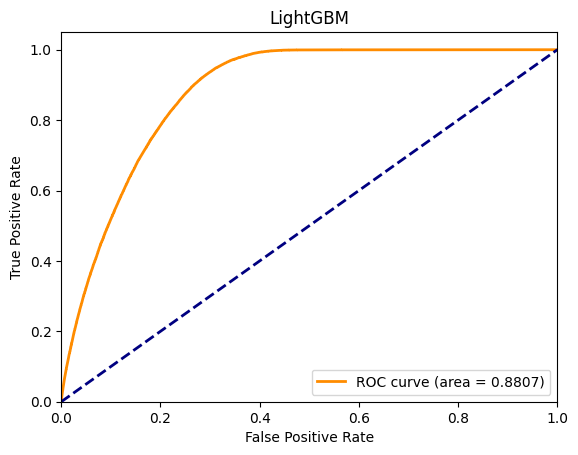

In [23]:
# 시각화
plt.figure()
plt.plot(fpr_lgb, tpr_lgb, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc_lgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM')
plt.legend(loc="lower right")
plt.show()

1. Gradient Boosting Tree : 0.8715 (33분 소요)
2. XGBoost : 0.8821 (1분 소요)
3. CatBoost : 0.8844 (31분 소요)
4. LightGBM : 0.8807 (2분 소요)

- 비교적 auc가 낮은 GBT 제외
- 시간 소모가 적은 XGBoost와 auc가 가장 높은 CatBoost 활용
- CatBoost : 범주형 변수에 대한 처리 지원, 수치형 변수가 많은 데이터셋일 경우 많은 시간 소요

## 하이퍼파라미터 튜닝

- public code 참고

### 1. XGBoost

In [21]:
!pip install optuna-integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 924.2 kB/s eta 0:00:000:00:010m


In [22]:
import xgboost as xgb
import optuna
from optuna import Trial
from optuna.logging import set_verbosity, INFO
from optuna.integration import XGBoostPruningCallback

In [23]:
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
    }

    # 모델 정의 및 학습
    model = xgb.XGBClassifier(**param, use_label_encoder=False)

    # 조기 중지를 위한 콜백 설정
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation_0-auc')

    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              early_stopping_rounds=50,
              callbacks=[pruning_callback],
              verbose=False)

    # 예측 및 성능 평가
    y_pred = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred)
    
    return roc_auc

# 진행 상황을 출력하는 콜백 함수 정의
def logging_callback(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value} and parameters: {trial.params}")

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, callbacks=[logging_callback])

# 최적의 결과 출력
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-07-22 00:56:50,384] A new study created in memory with name: no-name-6fc77104-4f77-49fe-85ba-6c59edec7f6b
[I 2024-07-22 00:57:50,273] Trial 0 finished with value: 0.8829491323489883 and parameters: {'lambda': 0.01322726588719814, 'alpha': 0.00046452613066167066, 'colsample_bytree': 0.6155191696588449, 'subsample': 0.9647887469689906, 'learning_rate': 0.2888696941328728, 'n_estimators': 601, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 3.0316031238053097e-06}. Best is trial 0 with value: 0.8829491323489883.


Trial 0 finished with value: 0.8829491323489883 and parameters: {'lambda': 0.01322726588719814, 'alpha': 0.00046452613066167066, 'colsample_bytree': 0.6155191696588449, 'subsample': 0.9647887469689906, 'learning_rate': 0.2888696941328728, 'n_estimators': 601, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 3.0316031238053097e-06}


[I 2024-07-22 00:58:01,276] Trial 1 finished with value: 0.8697826610472519 and parameters: {'lambda': 0.0004526241318838977, 'alpha': 3.677463595422523e-06, 'colsample_bytree': 0.16932963889854802, 'subsample': 0.10214857167785844, 'learning_rate': 0.15536083467584977, 'n_estimators': 103, 'max_depth': 4, 'min_child_weight': 3, 'gamma': 2.9682216617829536e-06}. Best is trial 0 with value: 0.8829491323489883.


Trial 1 finished with value: 0.8697826610472519 and parameters: {'lambda': 0.0004526241318838977, 'alpha': 3.677463595422523e-06, 'colsample_bytree': 0.16932963889854802, 'subsample': 0.10214857167785844, 'learning_rate': 0.15536083467584977, 'n_estimators': 103, 'max_depth': 4, 'min_child_weight': 3, 'gamma': 2.9682216617829536e-06}


[I 2024-07-22 00:58:23,662] Trial 2 finished with value: 0.8823567585060984 and parameters: {'lambda': 7.040367420778626e-08, 'alpha': 0.11637193001501266, 'colsample_bytree': 0.446305649836675, 'subsample': 0.8111028728780115, 'learning_rate': 0.2857531077498242, 'n_estimators': 606, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.0019373200209854}. Best is trial 0 with value: 0.8829491323489883.


Trial 2 finished with value: 0.8823567585060984 and parameters: {'lambda': 7.040367420778626e-08, 'alpha': 0.11637193001501266, 'colsample_bytree': 0.446305649836675, 'subsample': 0.8111028728780115, 'learning_rate': 0.2857531077498242, 'n_estimators': 606, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.0019373200209854}


[I 2024-07-22 00:59:19,568] Trial 3 finished with value: 0.8802004180992499 and parameters: {'lambda': 0.018351492470499955, 'alpha': 0.012727360186215453, 'colsample_bytree': 0.1595549873641651, 'subsample': 0.2812223198322237, 'learning_rate': 0.14159184565858637, 'n_estimators': 507, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 0.00037660210696404957}. Best is trial 0 with value: 0.8829491323489883.


Trial 3 finished with value: 0.8802004180992499 and parameters: {'lambda': 0.018351492470499955, 'alpha': 0.012727360186215453, 'colsample_bytree': 0.1595549873641651, 'subsample': 0.2812223198322237, 'learning_rate': 0.14159184565858637, 'n_estimators': 507, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 0.00037660210696404957}


[I 2024-07-22 01:00:12,762] Trial 4 finished with value: 0.8823056043781862 and parameters: {'lambda': 0.0009218477515440345, 'alpha': 4.459930269750783e-06, 'colsample_bytree': 0.4591038733993821, 'subsample': 0.7249625076066302, 'learning_rate': 0.22235388192481437, 'n_estimators': 529, 'max_depth': 3, 'min_child_weight': 3, 'gamma': 9.335491569714139e-08}. Best is trial 0 with value: 0.8829491323489883.


Trial 4 finished with value: 0.8823056043781862 and parameters: {'lambda': 0.0009218477515440345, 'alpha': 4.459930269750783e-06, 'colsample_bytree': 0.4591038733993821, 'subsample': 0.7249625076066302, 'learning_rate': 0.22235388192481437, 'n_estimators': 529, 'max_depth': 3, 'min_child_weight': 3, 'gamma': 9.335491569714139e-08}


[I 2024-07-22 01:00:38,764] Trial 5 finished with value: 0.8819027432469725 and parameters: {'lambda': 0.00199866407401479, 'alpha': 5.4132685500446076e-05, 'colsample_bytree': 0.5790047709104424, 'subsample': 0.48907645125131083, 'learning_rate': 0.12709209501578134, 'n_estimators': 199, 'max_depth': 6, 'min_child_weight': 9, 'gamma': 0.07737209061494556}. Best is trial 0 with value: 0.8829491323489883.


Trial 5 finished with value: 0.8819027432469725 and parameters: {'lambda': 0.00199866407401479, 'alpha': 5.4132685500446076e-05, 'colsample_bytree': 0.5790047709104424, 'subsample': 0.48907645125131083, 'learning_rate': 0.12709209501578134, 'n_estimators': 199, 'max_depth': 6, 'min_child_weight': 9, 'gamma': 0.07737209061494556}


[I 2024-07-22 01:00:39,804] Trial 6 pruned. Trial was pruned at iteration 0.


Trial 6 finished with value: 0.5637735987577428 and parameters: {'lambda': 2.8366755615197687e-06, 'alpha': 0.28644947224512984, 'colsample_bytree': 0.1957717119588605, 'subsample': 0.9991343790511424, 'learning_rate': 0.0965147731498476, 'n_estimators': 254, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.0007472707088078844}


[I 2024-07-22 01:00:42,188] Trial 7 pruned. Trial was pruned at iteration 9.


Trial 7 finished with value: 0.8563025984560789 and parameters: {'lambda': 0.000116188081863291, 'alpha': 6.665001516163908e-05, 'colsample_bytree': 0.33033623527924316, 'subsample': 0.43872974263194087, 'learning_rate': 0.050140083527754016, 'n_estimators': 318, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 2.700773498718149e-07}


[I 2024-07-22 01:01:21,446] Trial 8 finished with value: 0.8825008246376198 and parameters: {'lambda': 2.8128758222977443e-06, 'alpha': 0.4564204108468517, 'colsample_bytree': 0.9269753151651287, 'subsample': 0.6185560665946608, 'learning_rate': 0.18272556952983107, 'n_estimators': 965, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.0007825951097810297}. Best is trial 0 with value: 0.8829491323489883.


Trial 8 finished with value: 0.8825008246376198 and parameters: {'lambda': 2.8128758222977443e-06, 'alpha': 0.4564204108468517, 'colsample_bytree': 0.9269753151651287, 'subsample': 0.6185560665946608, 'learning_rate': 0.18272556952983107, 'n_estimators': 965, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.0007825951097810297}


[I 2024-07-22 01:02:04,601] Trial 9 finished with value: 0.8830548503687033 and parameters: {'lambda': 0.3117376576648139, 'alpha': 0.28104994064061856, 'colsample_bytree': 0.6125242432629404, 'subsample': 0.7551933178736452, 'learning_rate': 0.12510911640264208, 'n_estimators': 349, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 0.0012239504881760117}. Best is trial 9 with value: 0.8830548503687033.


Trial 9 finished with value: 0.8830548503687033 and parameters: {'lambda': 0.3117376576648139, 'alpha': 0.28104994064061856, 'colsample_bytree': 0.6125242432629404, 'subsample': 0.7551933178736452, 'learning_rate': 0.12510911640264208, 'n_estimators': 349, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 0.0012239504881760117}


[I 2024-07-22 01:02:05,722] Trial 10 pruned. Trial was pruned at iteration 0.


Trial 10 finished with value: 0.78782641103194 and parameters: {'lambda': 0.3111615213554872, 'alpha': 1.626418629868342e-08, 'colsample_bytree': 0.8028494769871851, 'subsample': 0.8095621026728039, 'learning_rate': 0.014966471489917366, 'n_estimators': 871, 'max_depth': 1, 'min_child_weight': 8, 'gamma': 0.5628482480891193}


[I 2024-07-22 01:02:06,829] Trial 11 pruned. Trial was pruned at iteration 0.


Trial 11 finished with value: 0.8234647439638881 and parameters: {'lambda': 0.6448257561893495, 'alpha': 0.0011805058819255748, 'colsample_bytree': 0.6974081511715922, 'subsample': 0.9841055588761434, 'learning_rate': 0.27476365461757246, 'n_estimators': 669, 'max_depth': 2, 'min_child_weight': 7, 'gamma': 1.451248307295786e-05}


[I 2024-07-22 01:02:07,960] Trial 12 pruned. Trial was pruned at iteration 0.


Trial 12 finished with value: 0.8439053898709359 and parameters: {'lambda': 0.03223085363947451, 'alpha': 0.004309616557159855, 'colsample_bytree': 0.6489258741962131, 'subsample': 0.8449255154532069, 'learning_rate': 0.21752576983332794, 'n_estimators': 414, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 1.1177896588756453e-08}


[I 2024-07-22 01:02:51,941] Trial 13 finished with value: 0.8826633535878842 and parameters: {'lambda': 0.031164431929102922, 'alpha': 2.0267544714946782e-08, 'colsample_bytree': 0.7806010790401302, 'subsample': 0.6698348718882453, 'learning_rate': 0.08886513209509964, 'n_estimators': 783, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 2.836053142430272e-05}. Best is trial 9 with value: 0.8830548503687033.


Trial 13 finished with value: 0.8826633535878842 and parameters: {'lambda': 0.031164431929102922, 'alpha': 2.0267544714946782e-08, 'colsample_bytree': 0.7806010790401302, 'subsample': 0.6698348718882453, 'learning_rate': 0.08886513209509964, 'n_estimators': 783, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 2.836053142430272e-05}


[I 2024-07-22 01:02:53,049] Trial 14 pruned. Trial was pruned at iteration 0.


Trial 14 finished with value: 0.8366325705700756 and parameters: {'lambda': 0.00818215303472495, 'alpha': 0.0005663509398494852, 'colsample_bytree': 0.4857281981400994, 'subsample': 0.8852844738636869, 'learning_rate': 0.2349942635323501, 'n_estimators': 399, 'max_depth': 3, 'min_child_weight': 10, 'gamma': 0.022760932615406345}


[I 2024-07-22 01:02:54,142] Trial 15 pruned. Trial was pruned at iteration 0.


Trial 15 finished with value: 0.78782641103194 and parameters: {'lambda': 0.8616133542141083, 'alpha': 0.02714027495214776, 'colsample_bytree': 0.9349691781484915, 'subsample': 0.7231487738932922, 'learning_rate': 0.09134728464526325, 'n_estimators': 683, 'max_depth': 1, 'min_child_weight': 7, 'gamma': 2.7521681917395093e-06}


[I 2024-07-22 01:02:55,261] Trial 16 pruned. Trial was pruned at iteration 0.


Trial 16 finished with value: 0.8460079718640791 and parameters: {'lambda': 0.1062657545278525, 'alpha': 1.4638120911569247e-06, 'colsample_bytree': 0.3366331785633957, 'subsample': 0.9132127683891038, 'learning_rate': 0.17770607069640307, 'n_estimators': 466, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 0.008803551229390333}


[I 2024-07-22 01:03:20,470] Trial 17 finished with value: 0.8821775984643263 and parameters: {'lambda': 1.6108823099942045e-05, 'alpha': 4.2996983132139765e-07, 'colsample_bytree': 0.5859837325887852, 'subsample': 0.564925961976537, 'learning_rate': 0.2577720358951392, 'n_estimators': 337, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.00011108451618159601}. Best is trial 9 with value: 0.8830548503687033.


Trial 17 finished with value: 0.8821775984643263 and parameters: {'lambda': 1.6108823099942045e-05, 'alpha': 4.2996983132139765e-07, 'colsample_bytree': 0.5859837325887852, 'subsample': 0.564925961976537, 'learning_rate': 0.2577720358951392, 'n_estimators': 337, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.00011108451618159601}


[I 2024-07-22 01:03:21,511] Trial 18 pruned. Trial was pruned at iteration 0.


Trial 18 finished with value: 0.8421987723304316 and parameters: {'lambda': 0.004552271261987784, 'alpha': 0.9229035323232342, 'colsample_bytree': 0.7956526616331318, 'subsample': 0.4082070102054236, 'learning_rate': 0.1964431171270631, 'n_estimators': 762, 'max_depth': 3, 'min_child_weight': 8, 'gamma': 7.414661612548094e-07}


[I 2024-07-22 01:03:40,890] Trial 19 finished with value: 0.8821635187422028 and parameters: {'lambda': 0.12047638979323945, 'alpha': 0.0008715399297809188, 'colsample_bytree': 0.6923510981278216, 'subsample': 0.7485358023883468, 'learning_rate': 0.29771539319130114, 'n_estimators': 562, 'max_depth': 8, 'min_child_weight': 4, 'gamma': 3.181819001263496e-05}. Best is trial 9 with value: 0.8830548503687033.


Trial 19 finished with value: 0.8821635187422028 and parameters: {'lambda': 0.12047638979323945, 'alpha': 0.0008715399297809188, 'colsample_bytree': 0.6923510981278216, 'subsample': 0.7485358023883468, 'learning_rate': 0.29771539319130114, 'n_estimators': 562, 'max_depth': 8, 'min_child_weight': 4, 'gamma': 3.181819001263496e-05}


[I 2024-07-22 01:03:41,996] Trial 20 pruned. Trial was pruned at iteration 0.


Trial 20 finished with value: 0.8442405219910925 and parameters: {'lambda': 0.00011518176213642565, 'alpha': 0.07005644592831388, 'colsample_bytree': 0.3350812259468466, 'subsample': 0.9396908162454121, 'learning_rate': 0.11631885502202784, 'n_estimators': 150, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 3.264546528003761e-08}


[I 2024-07-22 01:03:47,187] Trial 21 pruned. Trial was pruned at iteration 30.


Trial 21 finished with value: 0.8737013921891982 and parameters: {'lambda': 0.05811220119088721, 'alpha': 1.6991292807680038e-08, 'colsample_bytree': 0.8017219278001553, 'subsample': 0.6452299093781817, 'learning_rate': 0.06755657314333849, 'n_estimators': 839, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 9.959339609508056e-06}


[I 2024-07-22 01:03:52,335] Trial 22 pruned. Trial was pruned at iteration 28.


Trial 22 finished with value: 0.8734071367867207 and parameters: {'lambda': 0.007243914697529443, 'alpha': 1.9132515341863444e-05, 'colsample_bytree': 0.7489598208899736, 'subsample': 0.6579414827464268, 'learning_rate': 0.07004324098514592, 'n_estimators': 740, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.0001969446529630418}


[I 2024-07-22 01:03:53,444] Trial 23 pruned. Trial was pruned at iteration 0.


Trial 23 finished with value: 0.8197161705603301 and parameters: {'lambda': 0.14881830240883462, 'alpha': 1.0188163238541775e-07, 'colsample_bytree': 0.8733364221418873, 'subsample': 0.763971331883521, 'learning_rate': 0.15110773199574787, 'n_estimators': 603, 'max_depth': 2, 'min_child_weight': 9, 'gamma': 3.500876505045336e-05}


[I 2024-07-22 01:03:54,688] Trial 24 pruned. Trial was pruned at iteration 1.


Trial 24 finished with value: 0.8569404346384777 and parameters: {'lambda': 0.037516721356810216, 'alpha': 0.0002130731810547375, 'colsample_bytree': 0.6223811762551188, 'subsample': 0.5782019582878567, 'learning_rate': 0.018269465867502596, 'n_estimators': 995, 'max_depth': 6, 'min_child_weight': 7, 'gamma': 0.003746131864749742}


[I 2024-07-22 01:04:46,689] Trial 25 finished with value: 0.8833063147822717 and parameters: {'lambda': 0.99327440465053, 'alpha': 1.8039299639150409e-07, 'colsample_bytree': 0.5287064183581429, 'subsample': 0.6833088503252076, 'learning_rate': 0.09652895942196121, 'n_estimators': 828, 'max_depth': 8, 'min_child_weight': 4, 'gamma': 2.5609750575050474e-06}. Best is trial 25 with value: 0.8833063147822717.


Trial 25 finished with value: 0.8833063147822717 and parameters: {'lambda': 0.99327440465053, 'alpha': 1.8039299639150409e-07, 'colsample_bytree': 0.5287064183581429, 'subsample': 0.6833088503252076, 'learning_rate': 0.09652895942196121, 'n_estimators': 828, 'max_depth': 8, 'min_child_weight': 4, 'gamma': 2.5609750575050474e-06}


[I 2024-07-22 01:05:40,098] Trial 26 finished with value: 0.8831121085147008 and parameters: {'lambda': 0.8788472486293891, 'alpha': 2.517293185827753e-07, 'colsample_bytree': 0.519266500202914, 'subsample': 0.8337239771215879, 'learning_rate': 0.11697754660676779, 'n_estimators': 913, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 1.1939377649292099e-06}. Best is trial 25 with value: 0.8833063147822717.


Trial 26 finished with value: 0.8831121085147008 and parameters: {'lambda': 0.8788472486293891, 'alpha': 2.517293185827753e-07, 'colsample_bytree': 0.519266500202914, 'subsample': 0.8337239771215879, 'learning_rate': 0.11697754660676779, 'n_estimators': 913, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 1.1939377649292099e-06}


[I 2024-07-22 01:05:49,655] Trial 27 pruned. Trial was pruned at iteration 57.


Trial 27 finished with value: 0.8782443066247699 and parameters: {'lambda': 0.8982145778074095, 'alpha': 1.7696970647564952e-07, 'colsample_bytree': 0.5102884206955833, 'subsample': 0.8592378220461016, 'learning_rate': 0.10842994594290403, 'n_estimators': 907, 'max_depth': 8, 'min_child_weight': 4, 'gamma': 6.608527776195312e-07}


[I 2024-07-22 01:05:50,873] Trial 28 pruned. Trial was pruned at iteration 0.


Trial 28 finished with value: 0.8516130611614213 and parameters: {'lambda': 2.754699945166901e-08, 'alpha': 7.185360810626093e-07, 'colsample_bytree': 0.39693369380160937, 'subsample': 0.507305929531009, 'learning_rate': 0.0453463361555297, 'n_estimators': 934, 'max_depth': 8, 'min_child_weight': 3, 'gamma': 3.080760605079974e-07}


[I 2024-07-22 01:05:59,452] Trial 29 pruned. Trial was pruned at iteration 60.


Trial 29 finished with value: 0.8784297277528563 and parameters: {'lambda': 0.2653744608688435, 'alpha': 9.35750001146936e-08, 'colsample_bytree': 0.5216848441074435, 'subsample': 0.7797960181804605, 'learning_rate': 0.13384443933770707, 'n_estimators': 854, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 5.140858718666376e-06}


[I 2024-07-22 01:06:03,481] Trial 30 pruned. Trial was pruned at iteration 25.


Trial 30 finished with value: 0.8735978011919932 and parameters: {'lambda': 0.2804763737593769, 'alpha': 5.830213664055368e-06, 'colsample_bytree': 0.5541921168582029, 'subsample': 0.33293469994794705, 'learning_rate': 0.16412926895196284, 'n_estimators': 804, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 1.3941014065152056e-06}


[I 2024-07-22 01:06:04,614] Trial 31 pruned. Trial was pruned at iteration 0.


Trial 31 finished with value: 0.8542471606407123 and parameters: {'lambda': 0.8735042785080497, 'alpha': 1.1966535875482382e-05, 'colsample_bytree': 0.6455297604180186, 'subsample': 0.9567393518248205, 'learning_rate': 0.11499466961078597, 'n_estimators': 697, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 3.971477617255184e-06}


[I 2024-07-22 01:06:05,835] Trial 32 pruned. Trial was pruned at iteration 0.


Trial 32 finished with value: 0.8577580389285707 and parameters: {'lambda': 0.0004297109296451846, 'alpha': 1.9436374195257116e-06, 'colsample_bytree': 0.4298938560442568, 'subsample': 0.8803081622664044, 'learning_rate': 0.07301877740449952, 'n_estimators': 634, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 1.0257504528669758e-07}


[I 2024-07-22 01:06:43,199] Trial 33 finished with value: 0.882583862075107 and parameters: {'lambda': 0.014875827453138021, 'alpha': 0.003894351756643878, 'colsample_bytree': 0.7011484590484883, 'subsample': 0.8269516870820819, 'learning_rate': 0.1565514649593713, 'n_estimators': 453, 'max_depth': 8, 'min_child_weight': 3, 'gamma': 6.795523372611037e-05}. Best is trial 25 with value: 0.8833063147822717.


Trial 33 finished with value: 0.882583862075107 and parameters: {'lambda': 0.014875827453138021, 'alpha': 0.003894351756643878, 'colsample_bytree': 0.7011484590484883, 'subsample': 0.8269516870820819, 'learning_rate': 0.1565514649593713, 'n_estimators': 453, 'max_depth': 8, 'min_child_weight': 3, 'gamma': 6.795523372611037e-05}


[I 2024-07-22 01:06:44,330] Trial 34 pruned. Trial was pruned at iteration 0.


Trial 34 finished with value: 0.8543031999932857 and parameters: {'lambda': 0.07644472464520462, 'alpha': 3.032789477482987e-07, 'colsample_bytree': 0.40963672593683503, 'subsample': 0.7008849588683458, 'learning_rate': 0.13883074446829025, 'n_estimators': 909, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 1.3703690880103437e-07}


[I 2024-07-22 01:06:45,900] Trial 35 pruned. Trial was pruned at iteration 0.


Trial 35 finished with value: 0.8498009407338956 and parameters: {'lambda': 0.29963889269890126, 'alpha': 5.472714101786538e-08, 'colsample_bytree': 0.5855678958850075, 'subsample': 0.7832190363777637, 'learning_rate': 0.10405934441077022, 'n_estimators': 728, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 1.0078049015164722e-06}


[I 2024-07-22 01:06:47,205] Trial 36 pruned. Trial was pruned at iteration 0.


Trial 36 finished with value: 0.8476526878524577 and parameters: {'lambda': 0.0005308969010931426, 'alpha': 2.3408020804947548e-05, 'colsample_bytree': 0.48018985355233557, 'subsample': 0.12701050886033022, 'learning_rate': 0.13049023026903914, 'n_estimators': 101, 'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.00044603815326159157}


[I 2024-07-22 01:06:49,607] Trial 37 pruned. Trial was pruned at iteration 9.


Trial 37 finished with value: 0.8675936582233834 and parameters: {'lambda': 2.1369874843218726e-07, 'alpha': 0.011092784958957637, 'colsample_bytree': 0.6120530486964159, 'subsample': 0.9374345252863585, 'learning_rate': 0.04457000104520331, 'n_estimators': 248, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 9.721757448955258e-06}


[I 2024-07-22 01:06:50,826] Trial 38 pruned. Trial was pruned at iteration 0.


Trial 38 finished with value: 0.7339202285873662 and parameters: {'lambda': 0.0020357438142401896, 'alpha': 0.00034211747552734874, 'colsample_bytree': 0.23381841130225944, 'subsample': 0.7015396537877042, 'learning_rate': 0.20772237816955696, 'n_estimators': 823, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.0018823179758159325}


[I 2024-07-22 01:06:51,984] Trial 39 pruned. Trial was pruned at iteration 0.


Trial 39 finished with value: 0.8366883628860187 and parameters: {'lambda': 0.013094769339740357, 'alpha': 0.09205144322654524, 'colsample_bytree': 0.6725948758725182, 'subsample': 0.6206764308669539, 'learning_rate': 0.16997601666401455, 'n_estimators': 539, 'max_depth': 3, 'min_child_weight': 9, 'gamma': 2.49703918379076e-06}


[I 2024-07-22 01:07:20,035] Trial 40 finished with value: 0.8827234019100113 and parameters: {'lambda': 0.40230216389055773, 'alpha': 1.0195049347969969e-06, 'colsample_bytree': 0.5378711881267911, 'subsample': 0.8192767586401388, 'learning_rate': 0.2524023715501581, 'n_estimators': 335, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 3.45906580482676e-07}. Best is trial 25 with value: 0.8833063147822717.


Trial 40 finished with value: 0.8827234019100113 and parameters: {'lambda': 0.40230216389055773, 'alpha': 1.0195049347969969e-06, 'colsample_bytree': 0.5378711881267911, 'subsample': 0.8192767586401388, 'learning_rate': 0.2524023715501581, 'n_estimators': 335, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 3.45906580482676e-07}


[I 2024-07-22 01:07:43,605] Trial 41 finished with value: 0.882433527713031 and parameters: {'lambda': 0.30409224921794614, 'alpha': 4.568938517608582e-08, 'colsample_bytree': 0.5418504824585648, 'subsample': 0.8024174819904232, 'learning_rate': 0.25728790458782114, 'n_estimators': 325, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 3.9238682110616276e-07}. Best is trial 25 with value: 0.8833063147822717.


Trial 41 finished with value: 0.882433527713031 and parameters: {'lambda': 0.30409224921794614, 'alpha': 4.568938517608582e-08, 'colsample_bytree': 0.5418504824585648, 'subsample': 0.8024174819904232, 'learning_rate': 0.25728790458782114, 'n_estimators': 325, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 3.9238682110616276e-07}


[I 2024-07-22 01:07:44,709] Trial 42 pruned. Trial was pruned at iteration 0.


Trial 42 finished with value: 0.85606704552689 and parameters: {'lambda': 0.12401249408684872, 'alpha': 5.917321387855844e-07, 'colsample_bytree': 0.4496123403497599, 'subsample': 0.8899535380214262, 'learning_rate': 0.27889946592316595, 'n_estimators': 233, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 5.1282972952453226e-08}


[I 2024-07-22 01:07:45,864] Trial 43 pruned. Trial was pruned at iteration 0.


Trial 43 finished with value: 0.8551249562077843 and parameters: {'lambda': 0.9981026960952292, 'alpha': 1.4042184296997073e-06, 'colsample_bytree': 0.5597026776366107, 'subsample': 0.8316324955442078, 'learning_rate': 0.2349018296378639, 'n_estimators': 381, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 1.7610805367433925e-07}


[I 2024-07-22 01:08:08,563] Trial 44 finished with value: 0.8821849931735107 and parameters: {'lambda': 0.3782106810018464, 'alpha': 6.881695236494194e-05, 'colsample_bytree': 0.7276186466636125, 'subsample': 0.9946889667827485, 'learning_rate': 0.2628412336997838, 'n_estimators': 288, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 1.4014348059627113e-08}. Best is trial 25 with value: 0.8833063147822717.


Trial 44 finished with value: 0.8821849931735107 and parameters: {'lambda': 0.3782106810018464, 'alpha': 6.881695236494194e-05, 'colsample_bytree': 0.7276186466636125, 'subsample': 0.9946889667827485, 'learning_rate': 0.2628412336997838, 'n_estimators': 288, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 1.4014348059627113e-08}


[I 2024-07-22 01:08:09,852] Trial 45 pruned. Trial was pruned at iteration 1.


Trial 45 finished with value: 0.860258680983217 and parameters: {'lambda': 0.02285429613285821, 'alpha': 5.504558596238291e-06, 'colsample_bytree': 0.5076031607569979, 'subsample': 0.737535088488388, 'learning_rate': 0.08424044508027168, 'n_estimators': 173, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 2.067203840679756e-06}


[I 2024-07-22 01:08:11,021] Trial 46 pruned. Trial was pruned at iteration 0.


Trial 46 finished with value: 0.8197161705603301 and parameters: {'lambda': 0.05427824118118431, 'alpha': 0.0021060274265389716, 'colsample_bytree': 0.6149688679686557, 'subsample': 0.8581327706160449, 'learning_rate': 0.29024198886084673, 'n_estimators': 485, 'max_depth': 2, 'min_child_weight': 6, 'gamma': 6.255672821364657e-06}


[I 2024-07-22 01:08:12,179] Trial 47 pruned. Trial was pruned at iteration 0.


Trial 47 finished with value: 0.8523254920750764 and parameters: {'lambda': 1.817656450805122e-05, 'alpha': 0.00014182815771845105, 'colsample_bytree': 0.3811291839298764, 'subsample': 0.9148944053374805, 'learning_rate': 0.12199471347927968, 'n_estimators': 362, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 0.2716432594760331}


[I 2024-07-22 01:08:13,290] Trial 48 pruned. Trial was pruned at iteration 0.


Trial 48 finished with value: 0.8543143758968262 and parameters: {'lambda': 0.44643429938847184, 'alpha': 0.29773731662602493, 'colsample_bytree': 0.47982219534670756, 'subsample': 0.702398245529864, 'learning_rate': 0.24472582905074844, 'n_estimators': 428, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.001702999624126882}


[I 2024-07-22 01:08:14,426] Trial 49 pruned. Trial was pruned at iteration 0.


Trial 49 finished with value: 0.8592233769057999 and parameters: {'lambda': 0.19463907623535226, 'alpha': 2.429897477025369e-07, 'colsample_bytree': 0.6421836335241693, 'subsample': 0.9679843568379247, 'learning_rate': 0.19149799683775548, 'n_estimators': 507, 'max_depth': 6, 'min_child_weight': 8, 'gamma': 6.359157602827833e-08}
Best trial:
  Value:  0.8833063147822717
  Params: 
    lambda: 0.99327440465053
    alpha: 1.8039299639150409e-07
    colsample_bytree: 0.5287064183581429
    subsample: 0.6833088503252076
    learning_rate: 0.09652895942196121
    n_estimators: 828
    max_depth: 8
    min_child_weight: 4
    gamma: 2.5609750575050474e-06


In [23]:
# XGBoost 모델 초기화
xgb_model = XGBClassifier(**params, objective = 'binary:logistic', random_state = 0)

# 학습 진행 상황을 출력하면서 모델 학습
n_samples = X_train.shape[0]
chunk_size = n_samples // 20  # 진행 상황을 20단계로 나누어 출력

for i in tqdm(range(0, n_samples, chunk_size), desc="XGBoost Training Progress"):
    end = i + chunk_size if i + chunk_size < n_samples else n_samples
    xgb_model.fit(X_train[:end], y_train[:end])

# 예측 및 ROC AUC 계산
y_score_xgb = xgb_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
print(f"XGBoost ROC AUC: {roc_auc_xgb:.4f}")

XGBoost Training Progress: 100%|██████████| 21/21 [1:31:29<00:00, 261.42s/it]


XGBoost ROC AUC: 0.8767


### 2. CatBoost
- optuna 활용
- categorical 데이터에 특화되어 있으므로 수치형 변수 categorical로 변경

In [15]:
df.head()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,AgeGroup
0,0,1,0.557692,1,1,0,0.601270,0.932099,0.415225,0,1
1,0,1,0.538462,0,0,1,0.704075,0.018519,0.162630,1,4
2,0,1,0.403846,1,1,0,0.380614,0.932099,0.747405,0,1
3,0,1,0.961538,1,1,0,0.629617,0.932099,0.432526,0,0
4,0,1,0.807692,0,1,0,0.712101,0.932099,0.117647,0,0


In [37]:
df2 = df
df2.head()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,AgeGroup
0,0,1,0.557692,1,1,0,0.601270,0.932099,0.415225,0,1
1,0,1,0.538462,0,0,1,0.704075,0.018519,0.162630,1,4
2,0,1,0.403846,1,1,0,0.380614,0.932099,0.747405,0,1
3,0,1,0.961538,1,1,0,0.629617,0.932099,0.432526,0,0
4,0,1,0.807692,0,1,0,0.712101,0.932099,0.117647,0,0


In [38]:
from sklearn.preprocessing import KBinsDiscretizer
kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

In [39]:
df2[['Region_Code_Binned', 'Annual_Premium_Binned', 'Policy_Sales_Channel_Binned', 'Vintage_Binned']] = kbins.fit_transform(df2[['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']])

In [40]:
df2.head()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,AgeGroup,Region_Code_Binned,Annual_Premium_Binned,Policy_Sales_Channel_Binned,Vintage_Binned
0,0,1,0.557692,1,1,0,0.601270,0.932099,0.415225,0,1,2.0,3.0,3.0,1.0
1,0,1,0.538462,0,0,1,0.704075,0.018519,0.162630,1,4,2.0,3.0,0.0,0.0
2,0,1,0.403846,1,1,0,0.380614,0.932099,0.747405,0,1,1.0,0.0,3.0,3.0
3,0,1,0.961538,1,1,0,0.629617,0.932099,0.432526,0,0,3.0,3.0,3.0,1.0
4,0,1,0.807692,0,1,0,0.712101,0.932099,0.117647,0,0,3.0,4.0,3.0,0.0


In [41]:
df2 = df2.drop(['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'], axis = 1)

In [42]:
df2['Region_Code_Binned'] = df2['Region_Code_Binned'].astype(int)
df2['Annual_Premium_Binned'] = df2['Annual_Premium_Binned'].astype(int)
df2['Policy_Sales_Channel_Binned'] = df2['Policy_Sales_Channel_Binned'].astype(int)
df2['Vintage_Binned'] = df2['Vintage_Binned'].astype(int)

In [43]:
df2.rename(columns=lambda x: x.replace('_Binned', ''), inplace=True)

In [44]:
df2.head()

,Gender,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Response,AgeGroup,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage
0,0,1,1,1,0,0,1,2,3,3,1
1,0,1,0,0,1,1,4,2,3,0,0
2,0,1,1,1,0,0,1,1,0,3,3
3,0,1,1,1,0,0,0,3,3,3,1
4,0,1,0,1,0,0,0,3,4,3,0


In [46]:
# X, y 데이터
X2 = df2.drop('Response', axis = 1)
y2 = df2['Response']

In [47]:
# 데이터 분할
X_train2, X_val, y_train2, y_val = train_test_split(X2, y2, test_size=0.2, random_state=42)

# 데이터 표준화 (minmaxscaler)
scaler = MinMaxScaler()
X_train2 = scaler.fit_transform(X_train2)
X_val = scaler.transform(X_val)

In [51]:
set_verbosity(INFO)

def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 10.0),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50)
    }

    cat_model = CatBoostClassifier(**param, loss_function='Logloss', eval_metric='AUC', random_seed=0, logging_level='Silent')
    cat_model.fit(X_train2, y_train2, eval_set=(X_val, y_val), early_stopping_rounds=50)

    y_pred = cat_model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred)
    
    return roc_auc

# 진행 상황을 출력하는 콜백 함수 정의
def logging_callback(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value} and parameters: {trial.params}")

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, callbacks=[logging_callback])

# 최적의 결과 출력
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-07-21 12:55:57,575] A new study created in memory with name: no-name-b1d914e5-635b-4c06-ab90-158c765c050c
[I 2024-07-21 12:56:25,882] Trial 0 finished with value: 0.8656638394451284 and parameters: {'iterations': 237, 'depth': 9, 'learning_rate': 0.14522453053221882, 'l2_leaf_reg': 6.675457508729776, 'border_count': 114, 'bagging_temperature': 0.8846123128703771, 'random_strength': 4.801179169856059, 'od_type': 'IncToDec', 'od_wait': 18}. Best is trial 0 with value: 0.8656638394451284.


Trial 0 finished with value: 0.8656638394451284 and parameters: {'iterations': 237, 'depth': 9, 'learning_rate': 0.14522453053221882, 'l2_leaf_reg': 6.675457508729776, 'border_count': 114, 'bagging_temperature': 0.8846123128703771, 'random_strength': 4.801179169856059, 'od_type': 'IncToDec', 'od_wait': 18}


[I 2024-07-21 12:57:33,349] Trial 1 finished with value: 0.8657185096950609 and parameters: {'iterations': 852, 'depth': 4, 'learning_rate': 0.2126896388491227, 'l2_leaf_reg': 2.6061530824662142, 'border_count': 197, 'bagging_temperature': 0.6449066606553934, 'random_strength': 8.13750246855571, 'od_type': 'Iter', 'od_wait': 44}. Best is trial 1 with value: 0.8657185096950609.


Trial 1 finished with value: 0.8657185096950609 and parameters: {'iterations': 852, 'depth': 4, 'learning_rate': 0.2126896388491227, 'l2_leaf_reg': 2.6061530824662142, 'border_count': 197, 'bagging_temperature': 0.6449066606553934, 'random_strength': 8.13750246855571, 'od_type': 'Iter', 'od_wait': 44}


[I 2024-07-21 12:57:57,200] Trial 2 finished with value: 0.8656757661242972 and parameters: {'iterations': 869, 'depth': 6, 'learning_rate': 0.2878104368845596, 'l2_leaf_reg': 0.4925592468061171, 'border_count': 230, 'bagging_temperature': 0.3545395561800464, 'random_strength': 8.262101382279317, 'od_type': 'Iter', 'od_wait': 47}. Best is trial 1 with value: 0.8657185096950609.


Trial 2 finished with value: 0.8656757661242972 and parameters: {'iterations': 869, 'depth': 6, 'learning_rate': 0.2878104368845596, 'l2_leaf_reg': 0.4925592468061171, 'border_count': 230, 'bagging_temperature': 0.3545395561800464, 'random_strength': 8.262101382279317, 'od_type': 'Iter', 'od_wait': 47}


[I 2024-07-21 12:58:29,927] Trial 3 finished with value: 0.865710066323435 and parameters: {'iterations': 454, 'depth': 7, 'learning_rate': 0.152526534200548, 'l2_leaf_reg': 7.602110177940909, 'border_count': 235, 'bagging_temperature': 0.5303735562634204, 'random_strength': 2.843143874196751, 'od_type': 'IncToDec', 'od_wait': 15}. Best is trial 1 with value: 0.8657185096950609.


Trial 3 finished with value: 0.865710066323435 and parameters: {'iterations': 454, 'depth': 7, 'learning_rate': 0.152526534200548, 'l2_leaf_reg': 7.602110177940909, 'border_count': 235, 'bagging_temperature': 0.5303735562634204, 'random_strength': 2.843143874196751, 'od_type': 'IncToDec', 'od_wait': 15}


[I 2024-07-21 13:00:08,733] Trial 4 finished with value: 0.865636548376312 and parameters: {'iterations': 709, 'depth': 10, 'learning_rate': 0.032372824909218084, 'l2_leaf_reg': 1.9543939008951705, 'border_count': 91, 'bagging_temperature': 0.7040338778678205, 'random_strength': 8.9703442503953, 'od_type': 'Iter', 'od_wait': 42}. Best is trial 1 with value: 0.8657185096950609.


Trial 4 finished with value: 0.865636548376312 and parameters: {'iterations': 709, 'depth': 10, 'learning_rate': 0.032372824909218084, 'l2_leaf_reg': 1.9543939008951705, 'border_count': 91, 'bagging_temperature': 0.7040338778678205, 'random_strength': 8.9703442503953, 'od_type': 'Iter', 'od_wait': 42}


[I 2024-07-21 13:00:39,048] Trial 5 finished with value: 0.8656567362489735 and parameters: {'iterations': 307, 'depth': 7, 'learning_rate': 0.18840218193624148, 'l2_leaf_reg': 6.145617123050274, 'border_count': 146, 'bagging_temperature': 0.05864574265891942, 'random_strength': 5.587098126567028, 'od_type': 'Iter', 'od_wait': 25}. Best is trial 1 with value: 0.8657185096950609.


Trial 5 finished with value: 0.8656567362489735 and parameters: {'iterations': 307, 'depth': 7, 'learning_rate': 0.18840218193624148, 'l2_leaf_reg': 6.145617123050274, 'border_count': 146, 'bagging_temperature': 0.05864574265891942, 'random_strength': 5.587098126567028, 'od_type': 'Iter', 'od_wait': 25}


[I 2024-07-21 13:01:02,134] Trial 6 finished with value: 0.8656444150956616 and parameters: {'iterations': 379, 'depth': 6, 'learning_rate': 0.29585471710999034, 'l2_leaf_reg': 7.849774315886828, 'border_count': 234, 'bagging_temperature': 0.3029971368197901, 'random_strength': 0.7270190729616122, 'od_type': 'IncToDec', 'od_wait': 22}. Best is trial 1 with value: 0.8657185096950609.


Trial 6 finished with value: 0.8656444150956616 and parameters: {'iterations': 379, 'depth': 6, 'learning_rate': 0.29585471710999034, 'l2_leaf_reg': 7.849774315886828, 'border_count': 234, 'bagging_temperature': 0.3029971368197901, 'random_strength': 0.7270190729616122, 'od_type': 'IncToDec', 'od_wait': 22}


[I 2024-07-21 13:01:35,367] Trial 7 finished with value: 0.8656761183633714 and parameters: {'iterations': 733, 'depth': 7, 'learning_rate': 0.14047322667431045, 'l2_leaf_reg': 0.41134580853628583, 'border_count': 124, 'bagging_temperature': 0.0704975581422973, 'random_strength': 6.207767189757404, 'od_type': 'IncToDec', 'od_wait': 27}. Best is trial 1 with value: 0.8657185096950609.


Trial 7 finished with value: 0.8656761183633714 and parameters: {'iterations': 733, 'depth': 7, 'learning_rate': 0.14047322667431045, 'l2_leaf_reg': 0.41134580853628583, 'border_count': 124, 'bagging_temperature': 0.0704975581422973, 'random_strength': 6.207767189757404, 'od_type': 'IncToDec', 'od_wait': 27}


[I 2024-07-21 13:02:04,653] Trial 8 finished with value: 0.8656229687160039 and parameters: {'iterations': 342, 'depth': 9, 'learning_rate': 0.1622081356219255, 'l2_leaf_reg': 9.020687584106298, 'border_count': 223, 'bagging_temperature': 0.6938098385722755, 'random_strength': 7.22972871904477, 'od_type': 'Iter', 'od_wait': 44}. Best is trial 1 with value: 0.8657185096950609.


Trial 8 finished with value: 0.8656229687160039 and parameters: {'iterations': 342, 'depth': 9, 'learning_rate': 0.1622081356219255, 'l2_leaf_reg': 9.020687584106298, 'border_count': 223, 'bagging_temperature': 0.6938098385722755, 'random_strength': 7.22972871904477, 'od_type': 'Iter', 'od_wait': 44}


[I 2024-07-21 13:02:51,038] Trial 9 finished with value: 0.8656653157113772 and parameters: {'iterations': 596, 'depth': 4, 'learning_rate': 0.20340247942731168, 'l2_leaf_reg': 2.8848413166065154, 'border_count': 76, 'bagging_temperature': 0.6943463354988066, 'random_strength': 8.166803684363607, 'od_type': 'Iter', 'od_wait': 12}. Best is trial 1 with value: 0.8657185096950609.


Trial 9 finished with value: 0.8656653157113772 and parameters: {'iterations': 596, 'depth': 4, 'learning_rate': 0.20340247942731168, 'l2_leaf_reg': 2.8848413166065154, 'border_count': 76, 'bagging_temperature': 0.6943463354988066, 'random_strength': 8.166803684363607, 'od_type': 'Iter', 'od_wait': 12}


[I 2024-07-21 13:04:40,138] Trial 10 finished with value: 0.8656875548916076 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.07676143072888522, 'l2_leaf_reg': 3.9899595768425273, 'border_count': 178, 'bagging_temperature': 0.882634521554938, 'random_strength': 9.719585002781388, 'od_type': 'Iter', 'od_wait': 36}. Best is trial 1 with value: 0.8657185096950609.


Trial 10 finished with value: 0.8656875548916076 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.07676143072888522, 'l2_leaf_reg': 3.9899595768425273, 'border_count': 178, 'bagging_temperature': 0.882634521554938, 'random_strength': 9.719585002781388, 'od_type': 'Iter', 'od_wait': 36}


[I 2024-07-21 13:05:12,927] Trial 11 finished with value: 0.8656914420588645 and parameters: {'iterations': 479, 'depth': 5, 'learning_rate': 0.23549897255188176, 'l2_leaf_reg': 5.222970825755705, 'border_count': 184, 'bagging_temperature': 0.5358458371989469, 'random_strength': 3.2082466127804867, 'od_type': 'IncToDec', 'od_wait': 36}. Best is trial 1 with value: 0.8657185096950609.


Trial 11 finished with value: 0.8656914420588645 and parameters: {'iterations': 479, 'depth': 5, 'learning_rate': 0.23549897255188176, 'l2_leaf_reg': 5.222970825755705, 'border_count': 184, 'bagging_temperature': 0.5358458371989469, 'random_strength': 3.2082466127804867, 'od_type': 'IncToDec', 'od_wait': 36}


[I 2024-07-21 13:05:51,146] Trial 12 finished with value: 0.8657115448310141 and parameters: {'iterations': 548, 'depth': 8, 'learning_rate': 0.10714864753428294, 'l2_leaf_reg': 9.964378755065262, 'border_count': 255, 'bagging_temperature': 0.48874013581653186, 'random_strength': 3.2517104841228885, 'od_type': 'IncToDec', 'od_wait': 12}. Best is trial 1 with value: 0.8657185096950609.


Trial 12 finished with value: 0.8657115448310141 and parameters: {'iterations': 548, 'depth': 8, 'learning_rate': 0.10714864753428294, 'l2_leaf_reg': 9.964378755065262, 'border_count': 255, 'bagging_temperature': 0.48874013581653186, 'random_strength': 3.2517104841228885, 'od_type': 'IncToDec', 'od_wait': 12}


[I 2024-07-21 13:06:11,290] Trial 13 finished with value: 0.8655779630125346 and parameters: {'iterations': 144, 'depth': 8, 'learning_rate': 0.08132800871948452, 'l2_leaf_reg': 3.89725610056073, 'border_count': 191, 'bagging_temperature': 0.38163599928880343, 'random_strength': 3.8788444200033108, 'od_type': 'IncToDec', 'od_wait': 33}. Best is trial 1 with value: 0.8657185096950609.


Trial 13 finished with value: 0.8655779630125346 and parameters: {'iterations': 144, 'depth': 8, 'learning_rate': 0.08132800871948452, 'l2_leaf_reg': 3.89725610056073, 'border_count': 191, 'bagging_temperature': 0.38163599928880343, 'random_strength': 3.8788444200033108, 'od_type': 'IncToDec', 'od_wait': 33}


[I 2024-07-21 13:06:48,972] Trial 14 finished with value: 0.8657015498984477 and parameters: {'iterations': 626, 'depth': 8, 'learning_rate': 0.09638693765657186, 'l2_leaf_reg': 9.5445974293784, 'border_count': 38, 'bagging_temperature': 0.6027891489935507, 'random_strength': 1.3951305791778124, 'od_type': 'IncToDec', 'od_wait': 50}. Best is trial 1 with value: 0.8657185096950609.


Trial 14 finished with value: 0.8657015498984477 and parameters: {'iterations': 626, 'depth': 8, 'learning_rate': 0.09638693765657186, 'l2_leaf_reg': 9.5445974293784, 'border_count': 38, 'bagging_temperature': 0.6027891489935507, 'random_strength': 1.3951305791778124, 'od_type': 'IncToDec', 'od_wait': 50}


[I 2024-07-21 13:07:17,301] Trial 15 finished with value: 0.8656890360607665 and parameters: {'iterations': 851, 'depth': 5, 'learning_rate': 0.24090939884205614, 'l2_leaf_reg': 2.270657571692959, 'border_count': 251, 'bagging_temperature': 0.20100485786893352, 'random_strength': 2.185618018790189, 'od_type': 'Iter', 'od_wait': 40}. Best is trial 1 with value: 0.8657185096950609.


Trial 15 finished with value: 0.8656890360607665 and parameters: {'iterations': 851, 'depth': 5, 'learning_rate': 0.24090939884205614, 'l2_leaf_reg': 2.270657571692959, 'border_count': 251, 'bagging_temperature': 0.20100485786893352, 'random_strength': 2.185618018790189, 'od_type': 'Iter', 'od_wait': 40}


[I 2024-07-21 13:09:22,449] Trial 16 finished with value: 0.8656463921591624 and parameters: {'iterations': 798, 'depth': 10, 'learning_rate': 0.027565527480490376, 'l2_leaf_reg': 4.673031146820949, 'border_count': 206, 'bagging_temperature': 0.4508639592244073, 'random_strength': 4.4013527746170364, 'od_type': 'Iter', 'od_wait': 10}. Best is trial 1 with value: 0.8657185096950609.


Trial 16 finished with value: 0.8656463921591624 and parameters: {'iterations': 798, 'depth': 10, 'learning_rate': 0.027565527480490376, 'l2_leaf_reg': 4.673031146820949, 'border_count': 206, 'bagging_temperature': 0.4508639592244073, 'random_strength': 4.4013527746170364, 'od_type': 'Iter', 'od_wait': 10}


[I 2024-07-21 13:10:07,280] Trial 17 finished with value: 0.8656479891070425 and parameters: {'iterations': 969, 'depth': 8, 'learning_rate': 0.10120957941035509, 'l2_leaf_reg': 1.7594121398366687, 'border_count': 159, 'bagging_temperature': 0.8102899264498287, 'random_strength': 6.63051646864151, 'od_type': 'IncToDec', 'od_wait': 30}. Best is trial 1 with value: 0.8657185096950609.


Trial 17 finished with value: 0.8656479891070425 and parameters: {'iterations': 969, 'depth': 8, 'learning_rate': 0.10120957941035509, 'l2_leaf_reg': 1.7594121398366687, 'border_count': 159, 'bagging_temperature': 0.8102899264498287, 'random_strength': 6.63051646864151, 'od_type': 'IncToDec', 'od_wait': 30}


[I 2024-07-21 13:10:35,023] Trial 18 finished with value: 0.8656953197705092 and parameters: {'iterations': 543, 'depth': 6, 'learning_rate': 0.24675886252357077, 'l2_leaf_reg': 9.91380078681976, 'border_count': 253, 'bagging_temperature': 0.9813374368164999, 'random_strength': 7.20556171049902, 'od_type': 'IncToDec', 'od_wait': 19}. Best is trial 1 with value: 0.8657185096950609.


Trial 18 finished with value: 0.8656953197705092 and parameters: {'iterations': 543, 'depth': 6, 'learning_rate': 0.24675886252357077, 'l2_leaf_reg': 9.91380078681976, 'border_count': 253, 'bagging_temperature': 0.9813374368164999, 'random_strength': 7.20556171049902, 'od_type': 'IncToDec', 'od_wait': 19}


[I 2024-07-21 13:11:10,029] Trial 19 finished with value: 0.8656972641946364 and parameters: {'iterations': 691, 'depth': 5, 'learning_rate': 0.19818669800346295, 'l2_leaf_reg': 3.2183763800502914, 'border_count': 205, 'bagging_temperature': 0.22927619640387709, 'random_strength': 5.223932143830101, 'od_type': 'Iter', 'od_wait': 38}. Best is trial 1 with value: 0.8657185096950609.


Trial 19 finished with value: 0.8656972641946364 and parameters: {'iterations': 691, 'depth': 5, 'learning_rate': 0.19818669800346295, 'l2_leaf_reg': 3.2183763800502914, 'border_count': 205, 'bagging_temperature': 0.22927619640387709, 'random_strength': 5.223932143830101, 'od_type': 'Iter', 'od_wait': 38}


[I 2024-07-21 13:11:41,232] Trial 20 finished with value: 0.8656758779806903 and parameters: {'iterations': 481, 'depth': 9, 'learning_rate': 0.11424969336601651, 'l2_leaf_reg': 8.527920561146043, 'border_count': 167, 'bagging_temperature': 0.6201274357704619, 'random_strength': 0.4856161737686655, 'od_type': 'Iter', 'od_wait': 30}. Best is trial 1 with value: 0.8657185096950609.


Trial 20 finished with value: 0.8656758779806903 and parameters: {'iterations': 481, 'depth': 9, 'learning_rate': 0.11424969336601651, 'l2_leaf_reg': 8.527920561146043, 'border_count': 167, 'bagging_temperature': 0.6201274357704619, 'random_strength': 0.4856161737686655, 'od_type': 'Iter', 'od_wait': 30}


[I 2024-07-21 13:12:08,259] Trial 21 finished with value: 0.8656940098529978 and parameters: {'iterations': 451, 'depth': 7, 'learning_rate': 0.17038497452408757, 'l2_leaf_reg': 7.213106344232718, 'border_count': 217, 'bagging_temperature': 0.4572103598121075, 'random_strength': 2.6600177957459117, 'od_type': 'IncToDec', 'od_wait': 15}. Best is trial 1 with value: 0.8657185096950609.


Trial 21 finished with value: 0.8656940098529978 and parameters: {'iterations': 451, 'depth': 7, 'learning_rate': 0.17038497452408757, 'l2_leaf_reg': 7.213106344232718, 'border_count': 217, 'bagging_temperature': 0.4572103598121075, 'random_strength': 2.6600177957459117, 'od_type': 'IncToDec', 'od_wait': 15}


[I 2024-07-21 13:12:38,849] Trial 22 finished with value: 0.8657251657458092 and parameters: {'iterations': 583, 'depth': 8, 'learning_rate': 0.12710481247650274, 'l2_leaf_reg': 8.108530762118711, 'border_count': 245, 'bagging_temperature': 0.5694278855747403, 'random_strength': 3.716258824780474, 'od_type': 'IncToDec', 'od_wait': 15}. Best is trial 22 with value: 0.8657251657458092.


Trial 22 finished with value: 0.8657251657458092 and parameters: {'iterations': 583, 'depth': 8, 'learning_rate': 0.12710481247650274, 'l2_leaf_reg': 8.108530762118711, 'border_count': 245, 'bagging_temperature': 0.5694278855747403, 'random_strength': 3.716258824780474, 'od_type': 'IncToDec', 'od_wait': 15}


[I 2024-07-21 13:13:42,397] Trial 23 finished with value: 0.8656789195360283 and parameters: {'iterations': 610, 'depth': 8, 'learning_rate': 0.05986066711262476, 'l2_leaf_reg': 8.219958423453738, 'border_count': 254, 'bagging_temperature': 0.6073294217342168, 'random_strength': 3.4490662919653383, 'od_type': 'IncToDec', 'od_wait': 14}. Best is trial 22 with value: 0.8657251657458092.


Trial 23 finished with value: 0.8656789195360283 and parameters: {'iterations': 610, 'depth': 8, 'learning_rate': 0.05986066711262476, 'l2_leaf_reg': 8.219958423453738, 'border_count': 254, 'bagging_temperature': 0.6073294217342168, 'random_strength': 3.4490662919653383, 'od_type': 'IncToDec', 'od_wait': 14}


[I 2024-07-21 13:14:10,204] Trial 24 finished with value: 0.8656557826329478 and parameters: {'iterations': 914, 'depth': 9, 'learning_rate': 0.11801838420193725, 'l2_leaf_reg': 5.734579922218922, 'border_count': 203, 'bagging_temperature': 0.7723286529448518, 'random_strength': 1.9408791461588462, 'od_type': 'IncToDec', 'od_wait': 20}. Best is trial 22 with value: 0.8657251657458092.


Trial 24 finished with value: 0.8656557826329478 and parameters: {'iterations': 914, 'depth': 9, 'learning_rate': 0.11801838420193725, 'l2_leaf_reg': 5.734579922218922, 'border_count': 203, 'bagging_temperature': 0.7723286529448518, 'random_strength': 1.9408791461588462, 'od_type': 'IncToDec', 'od_wait': 20}


[I 2024-07-21 13:14:45,759] Trial 25 finished with value: 0.8656779125483232 and parameters: {'iterations': 775, 'depth': 8, 'learning_rate': 0.12647402866602067, 'l2_leaf_reg': 9.037601718494953, 'border_count': 239, 'bagging_temperature': 0.4953714256257246, 'random_strength': 4.420276492769926, 'od_type': 'IncToDec', 'od_wait': 10}. Best is trial 22 with value: 0.8657251657458092.


Trial 25 finished with value: 0.8656779125483232 and parameters: {'iterations': 775, 'depth': 8, 'learning_rate': 0.12647402866602067, 'l2_leaf_reg': 9.037601718494953, 'border_count': 239, 'bagging_temperature': 0.4953714256257246, 'random_strength': 4.420276492769926, 'od_type': 'IncToDec', 'od_wait': 10}


[I 2024-07-21 13:15:17,439] Trial 26 finished with value: 0.8657039903570001 and parameters: {'iterations': 675, 'depth': 6, 'learning_rate': 0.21769761158881287, 'l2_leaf_reg': 9.957052428250863, 'border_count': 213, 'bagging_temperature': 0.39537596813812914, 'random_strength': 3.7573789956577377, 'od_type': 'IncToDec', 'od_wait': 23}. Best is trial 22 with value: 0.8657251657458092.


Trial 26 finished with value: 0.8657039903570001 and parameters: {'iterations': 675, 'depth': 6, 'learning_rate': 0.21769761158881287, 'l2_leaf_reg': 9.957052428250863, 'border_count': 213, 'bagging_temperature': 0.39537596813812914, 'random_strength': 3.7573789956577377, 'od_type': 'IncToDec', 'od_wait': 23}


[I 2024-07-21 13:16:33,105] Trial 27 finished with value: 0.8657185088545619 and parameters: {'iterations': 541, 'depth': 7, 'learning_rate': 0.055048983752005995, 'l2_leaf_reg': 7.0404576827707, 'border_count': 197, 'bagging_temperature': 0.5622819335758321, 'random_strength': 5.873182057800944, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 22 with value: 0.8657251657458092.


Trial 27 finished with value: 0.8657185088545619 and parameters: {'iterations': 541, 'depth': 7, 'learning_rate': 0.055048983752005995, 'l2_leaf_reg': 7.0404576827707, 'border_count': 197, 'bagging_temperature': 0.5622819335758321, 'random_strength': 5.873182057800944, 'od_type': 'IncToDec', 'od_wait': 17}


[I 2024-07-21 13:18:25,538] Trial 28 finished with value: 0.8656443683779319 and parameters: {'iterations': 784, 'depth': 4, 'learning_rate': 0.049465868787156086, 'l2_leaf_reg': 6.912080321785938, 'border_count': 193, 'bagging_temperature': 0.5851972987766281, 'random_strength': 5.783368440232663, 'od_type': 'Iter', 'od_wait': 27}. Best is trial 22 with value: 0.8657251657458092.


Trial 28 finished with value: 0.8656443683779319 and parameters: {'iterations': 784, 'depth': 4, 'learning_rate': 0.049465868787156086, 'l2_leaf_reg': 6.912080321785938, 'border_count': 193, 'bagging_temperature': 0.5851972987766281, 'random_strength': 5.783368440232663, 'od_type': 'Iter', 'od_wait': 27}


[I 2024-07-21 13:18:49,672] Trial 29 finished with value: 0.8655648847798525 and parameters: {'iterations': 234, 'depth': 9, 'learning_rate': 0.2644301738800655, 'l2_leaf_reg': 6.4212297711772415, 'border_count': 123, 'bagging_temperature': 0.8305032453829906, 'random_strength': 7.8588434298137235, 'od_type': 'IncToDec', 'od_wait': 16}. Best is trial 22 with value: 0.8657251657458092.


Trial 29 finished with value: 0.8655648847798525 and parameters: {'iterations': 234, 'depth': 9, 'learning_rate': 0.2644301738800655, 'l2_leaf_reg': 6.4212297711772415, 'border_count': 123, 'bagging_temperature': 0.8305032453829906, 'random_strength': 7.8588434298137235, 'od_type': 'IncToDec', 'od_wait': 16}


[I 2024-07-21 13:19:52,213] Trial 30 finished with value: 0.8644076305129956 and parameters: {'iterations': 392, 'depth': 5, 'learning_rate': 0.01720575423681104, 'l2_leaf_reg': 5.170672791430381, 'border_count': 165, 'bagging_temperature': 0.6783673063106495, 'random_strength': 9.75930223007619, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 22 with value: 0.8657251657458092.


Trial 30 finished with value: 0.8644076305129956 and parameters: {'iterations': 392, 'depth': 5, 'learning_rate': 0.01720575423681104, 'l2_leaf_reg': 5.170672791430381, 'border_count': 165, 'bagging_temperature': 0.6783673063106495, 'random_strength': 9.75930223007619, 'od_type': 'IncToDec', 'od_wait': 17}


[I 2024-07-21 13:20:25,750] Trial 31 finished with value: 0.8656501241843335 and parameters: {'iterations': 550, 'depth': 8, 'learning_rate': 0.13824512071193165, 'l2_leaf_reg': 9.010263990493632, 'border_count': 242, 'bagging_temperature': 0.5420697479514714, 'random_strength': 4.61686463163873, 'od_type': 'IncToDec', 'od_wait': 12}. Best is trial 22 with value: 0.8657251657458092.


Trial 31 finished with value: 0.8656501241843335 and parameters: {'iterations': 550, 'depth': 8, 'learning_rate': 0.13824512071193165, 'l2_leaf_reg': 9.010263990493632, 'border_count': 242, 'bagging_temperature': 0.5420697479514714, 'random_strength': 4.61686463163873, 'od_type': 'IncToDec', 'od_wait': 12}


[I 2024-07-21 13:20:50,628] Trial 32 finished with value: 0.8655991727217148 and parameters: {'iterations': 537, 'depth': 9, 'learning_rate': 0.1776399089290743, 'l2_leaf_reg': 1.089266872356472, 'border_count': 230, 'bagging_temperature': 0.42469450111714047, 'random_strength': 5.1080923077148945, 'od_type': 'IncToDec', 'od_wait': 20}. Best is trial 22 with value: 0.8657251657458092.


Trial 32 finished with value: 0.8655991727217148 and parameters: {'iterations': 537, 'depth': 9, 'learning_rate': 0.1776399089290743, 'l2_leaf_reg': 1.089266872356472, 'border_count': 230, 'bagging_temperature': 0.42469450111714047, 'random_strength': 5.1080923077148945, 'od_type': 'IncToDec', 'od_wait': 20}


[I 2024-07-21 13:22:02,040] Trial 33 finished with value: 0.8657116650923962 and parameters: {'iterations': 631, 'depth': 7, 'learning_rate': 0.06411906606873756, 'l2_leaf_reg': 7.23613065968516, 'border_count': 221, 'bagging_temperature': 0.32668116686546295, 'random_strength': 6.368329692377495, 'od_type': 'IncToDec', 'od_wait': 13}. Best is trial 22 with value: 0.8657251657458092.


Trial 33 finished with value: 0.8657116650923962 and parameters: {'iterations': 631, 'depth': 7, 'learning_rate': 0.06411906606873756, 'l2_leaf_reg': 7.23613065968516, 'border_count': 221, 'bagging_temperature': 0.32668116686546295, 'random_strength': 6.368329692377495, 'od_type': 'IncToDec', 'od_wait': 13}


[I 2024-07-21 13:23:18,967] Trial 34 finished with value: 0.8657028263360868 and parameters: {'iterations': 668, 'depth': 7, 'learning_rate': 0.051482027455317214, 'l2_leaf_reg': 7.805692956820208, 'border_count': 220, 'bagging_temperature': 0.7430810193773492, 'random_strength': 8.74735784045517, 'od_type': 'IncToDec', 'od_wait': 18}. Best is trial 22 with value: 0.8657251657458092.


Trial 34 finished with value: 0.8657028263360868 and parameters: {'iterations': 668, 'depth': 7, 'learning_rate': 0.051482027455317214, 'l2_leaf_reg': 7.805692956820208, 'border_count': 220, 'bagging_temperature': 0.7430810193773492, 'random_strength': 8.74735784045517, 'od_type': 'IncToDec', 'od_wait': 18}


[I 2024-07-21 13:24:28,333] Trial 35 finished with value: 0.8657120513016335 and parameters: {'iterations': 851, 'depth': 6, 'learning_rate': 0.07169606900896221, 'l2_leaf_reg': 7.24463172177191, 'border_count': 144, 'bagging_temperature': 0.3132253918307561, 'random_strength': 6.839420085914288, 'od_type': 'IncToDec', 'od_wait': 46}. Best is trial 22 with value: 0.8657251657458092.


Trial 35 finished with value: 0.8657120513016335 and parameters: {'iterations': 851, 'depth': 6, 'learning_rate': 0.07169606900896221, 'l2_leaf_reg': 7.24463172177191, 'border_count': 144, 'bagging_temperature': 0.3132253918307561, 'random_strength': 6.839420085914288, 'od_type': 'IncToDec', 'od_wait': 46}


[I 2024-07-21 13:25:39,662] Trial 36 finished with value: 0.8656790781801925 and parameters: {'iterations': 876, 'depth': 6, 'learning_rate': 0.08102969960148955, 'l2_leaf_reg': 6.033675041862039, 'border_count': 139, 'bagging_temperature': 0.15552309565430023, 'random_strength': 7.2488596809951025, 'od_type': 'Iter', 'od_wait': 46}. Best is trial 22 with value: 0.8657251657458092.


Trial 36 finished with value: 0.8656790781801925 and parameters: {'iterations': 876, 'depth': 6, 'learning_rate': 0.08102969960148955, 'l2_leaf_reg': 6.033675041862039, 'border_count': 139, 'bagging_temperature': 0.15552309565430023, 'random_strength': 7.2488596809951025, 'od_type': 'Iter', 'od_wait': 46}


[I 2024-07-21 13:27:45,376] Trial 37 finished with value: 0.8656797818878836 and parameters: {'iterations': 929, 'depth': 6, 'learning_rate': 0.038082890138601375, 'l2_leaf_reg': 6.694666766285932, 'border_count': 107, 'bagging_temperature': 0.2774418166327633, 'random_strength': 8.758637916771939, 'od_type': 'IncToDec', 'od_wait': 49}. Best is trial 22 with value: 0.8657251657458092.


Trial 37 finished with value: 0.8656797818878836 and parameters: {'iterations': 929, 'depth': 6, 'learning_rate': 0.038082890138601375, 'l2_leaf_reg': 6.694666766285932, 'border_count': 107, 'bagging_temperature': 0.2774418166327633, 'random_strength': 8.758637916771939, 'od_type': 'IncToDec', 'od_wait': 49}


[I 2024-07-21 13:28:22,719] Trial 38 finished with value: 0.8656716658205316 and parameters: {'iterations': 825, 'depth': 7, 'learning_rate': 0.1556981377218931, 'l2_leaf_reg': 8.344528003414833, 'border_count': 140, 'bagging_temperature': 0.007130700539396684, 'random_strength': 7.679167159171284, 'od_type': 'Iter', 'od_wait': 44}. Best is trial 22 with value: 0.8657251657458092.


Trial 38 finished with value: 0.8656716658205316 and parameters: {'iterations': 825, 'depth': 7, 'learning_rate': 0.1556981377218931, 'l2_leaf_reg': 8.344528003414833, 'border_count': 140, 'bagging_temperature': 0.007130700539396684, 'random_strength': 7.679167159171284, 'od_type': 'Iter', 'od_wait': 44}


[I 2024-07-21 13:28:48,449] Trial 39 finished with value: 0.8657351319613303 and parameters: {'iterations': 732, 'depth': 5, 'learning_rate': 0.2818124919877404, 'l2_leaf_reg': 7.5449875863582045, 'border_count': 154, 'bagging_temperature': 0.5484042125957469, 'random_strength': 6.822583764763765, 'od_type': 'IncToDec', 'od_wait': 47}. Best is trial 39 with value: 0.8657351319613303.


Trial 39 finished with value: 0.8657351319613303 and parameters: {'iterations': 732, 'depth': 5, 'learning_rate': 0.2818124919877404, 'l2_leaf_reg': 7.5449875863582045, 'border_count': 154, 'bagging_temperature': 0.5484042125957469, 'random_strength': 6.822583764763765, 'od_type': 'IncToDec', 'od_wait': 47}


[I 2024-07-21 13:29:26,613] Trial 40 finished with value: 0.865693010079575 and parameters: {'iterations': 739, 'depth': 4, 'learning_rate': 0.2858202916556272, 'l2_leaf_reg': 5.693607470042421, 'border_count': 173, 'bagging_temperature': 0.6401666798641347, 'random_strength': 5.6600350512206035, 'od_type': 'Iter', 'od_wait': 48}. Best is trial 39 with value: 0.8657351319613303.


Trial 40 finished with value: 0.865693010079575 and parameters: {'iterations': 739, 'depth': 4, 'learning_rate': 0.2858202916556272, 'l2_leaf_reg': 5.693607470042421, 'border_count': 173, 'bagging_temperature': 0.6401666798641347, 'random_strength': 5.6600350512206035, 'od_type': 'Iter', 'od_wait': 48}


[I 2024-07-21 13:29:52,289] Trial 41 finished with value: 0.865611630876345 and parameters: {'iterations': 737, 'depth': 5, 'learning_rate': 0.27812748764201584, 'l2_leaf_reg': 7.619832283975088, 'border_count': 132, 'bagging_temperature': 0.5447866334414219, 'random_strength': 6.719957386690071, 'od_type': 'IncToDec', 'od_wait': 46}. Best is trial 39 with value: 0.8657351319613303.


Trial 41 finished with value: 0.865611630876345 and parameters: {'iterations': 737, 'depth': 5, 'learning_rate': 0.27812748764201584, 'l2_leaf_reg': 7.619832283975088, 'border_count': 132, 'bagging_temperature': 0.5447866334414219, 'random_strength': 6.719957386690071, 'od_type': 'IncToDec', 'od_wait': 46}


[I 2024-07-21 13:30:36,490] Trial 42 finished with value: 0.865683640408137 and parameters: {'iterations': 885, 'depth': 4, 'learning_rate': 0.2567224039754605, 'l2_leaf_reg': 7.221144492878542, 'border_count': 99, 'bagging_temperature': 0.5688927065785747, 'random_strength': 5.987580241362688, 'od_type': 'IncToDec', 'od_wait': 42}. Best is trial 39 with value: 0.8657351319613303.


Trial 42 finished with value: 0.865683640408137 and parameters: {'iterations': 885, 'depth': 4, 'learning_rate': 0.2567224039754605, 'l2_leaf_reg': 7.221144492878542, 'border_count': 99, 'bagging_temperature': 0.5688927065785747, 'random_strength': 5.987580241362688, 'od_type': 'IncToDec', 'od_wait': 42}


[I 2024-07-21 13:31:12,405] Trial 43 finished with value: 0.8657258737960776 and parameters: {'iterations': 829, 'depth': 5, 'learning_rate': 0.22929012594490542, 'l2_leaf_reg': 8.117064127003465, 'border_count': 158, 'bagging_temperature': 0.6468020270473513, 'random_strength': 7.123763881340135, 'od_type': 'IncToDec', 'od_wait': 43}. Best is trial 39 with value: 0.8657351319613303.


Trial 43 finished with value: 0.8657258737960776 and parameters: {'iterations': 829, 'depth': 5, 'learning_rate': 0.22929012594490542, 'l2_leaf_reg': 8.117064127003465, 'border_count': 158, 'bagging_temperature': 0.6468020270473513, 'random_strength': 7.123763881340135, 'od_type': 'IncToDec', 'od_wait': 43}


[I 2024-07-21 13:31:54,880] Trial 44 finished with value: 0.8656700861729201 and parameters: {'iterations': 498, 'depth': 5, 'learning_rate': 0.22363156805602682, 'l2_leaf_reg': 0.05752850495864559, 'border_count': 153, 'bagging_temperature': 0.6583050691948434, 'random_strength': 9.154372071759772, 'od_type': 'IncToDec', 'od_wait': 43}. Best is trial 39 with value: 0.8657351319613303.


Trial 44 finished with value: 0.8656700861729201 and parameters: {'iterations': 498, 'depth': 5, 'learning_rate': 0.22363156805602682, 'l2_leaf_reg': 0.05752850495864559, 'border_count': 153, 'bagging_temperature': 0.6583050691948434, 'random_strength': 9.154372071759772, 'od_type': 'IncToDec', 'od_wait': 43}


[I 2024-07-21 13:32:29,685] Trial 45 finished with value: 0.8656646161361391 and parameters: {'iterations': 417, 'depth': 4, 'learning_rate': 0.21281759848396145, 'l2_leaf_reg': 8.639483186623005, 'border_count': 182, 'bagging_temperature': 0.7271193310005565, 'random_strength': 7.994821616144131, 'od_type': 'IncToDec', 'od_wait': 40}. Best is trial 39 with value: 0.8657351319613303.


Trial 45 finished with value: 0.8656646161361391 and parameters: {'iterations': 417, 'depth': 4, 'learning_rate': 0.21281759848396145, 'l2_leaf_reg': 8.639483186623005, 'border_count': 182, 'bagging_temperature': 0.7271193310005565, 'random_strength': 7.994821616144131, 'od_type': 'IncToDec', 'od_wait': 40}


[I 2024-07-21 13:33:08,840] Trial 46 finished with value: 0.8656999128867875 and parameters: {'iterations': 596, 'depth': 5, 'learning_rate': 0.18801518553294494, 'l2_leaf_reg': 8.125814094528838, 'border_count': 194, 'bagging_temperature': 0.49799890727776125, 'random_strength': 7.308275896492022, 'od_type': 'IncToDec', 'od_wait': 33}. Best is trial 39 with value: 0.8657351319613303.


Trial 46 finished with value: 0.8656999128867875 and parameters: {'iterations': 596, 'depth': 5, 'learning_rate': 0.18801518553294494, 'l2_leaf_reg': 8.125814094528838, 'border_count': 194, 'bagging_temperature': 0.49799890727776125, 'random_strength': 7.308275896492022, 'od_type': 'IncToDec', 'od_wait': 33}


[I 2024-07-21 13:33:53,229] Trial 47 finished with value: 0.8657200521505968 and parameters: {'iterations': 759, 'depth': 4, 'learning_rate': 0.2712537306915596, 'l2_leaf_reg': 4.236179118087408, 'border_count': 158, 'bagging_temperature': 0.6482701161254745, 'random_strength': 8.324992483456809, 'od_type': 'Iter', 'od_wait': 40}. Best is trial 39 with value: 0.8657351319613303.


Trial 47 finished with value: 0.8657200521505968 and parameters: {'iterations': 759, 'depth': 4, 'learning_rate': 0.2712537306915596, 'l2_leaf_reg': 4.236179118087408, 'border_count': 158, 'bagging_temperature': 0.6482701161254745, 'random_strength': 8.324992483456809, 'od_type': 'Iter', 'od_wait': 40}


[I 2024-07-21 13:34:34,301] Trial 48 finished with value: 0.865699628377915 and parameters: {'iterations': 814, 'depth': 4, 'learning_rate': 0.2988608811376633, 'l2_leaf_reg': 4.5150618377979, 'border_count': 153, 'bagging_temperature': 0.7876223361322183, 'random_strength': 8.442386213215133, 'od_type': 'Iter', 'od_wait': 40}. Best is trial 39 with value: 0.8657351319613303.


Trial 48 finished with value: 0.865699628377915 and parameters: {'iterations': 814, 'depth': 4, 'learning_rate': 0.2988608811376633, 'l2_leaf_reg': 4.5150618377979, 'border_count': 153, 'bagging_temperature': 0.7876223361322183, 'random_strength': 8.442386213215133, 'od_type': 'Iter', 'od_wait': 40}


[I 2024-07-21 13:35:10,846] Trial 49 finished with value: 0.8656966877524849 and parameters: {'iterations': 757, 'depth': 4, 'learning_rate': 0.2776606531863128, 'l2_leaf_reg': 3.488005944161024, 'border_count': 119, 'bagging_temperature': 0.7127883608274634, 'random_strength': 9.195775160423707, 'od_type': 'Iter', 'od_wait': 36}. Best is trial 39 with value: 0.8657351319613303.


Trial 49 finished with value: 0.8656966877524849 and parameters: {'iterations': 757, 'depth': 4, 'learning_rate': 0.2776606531863128, 'l2_leaf_reg': 3.488005944161024, 'border_count': 119, 'bagging_temperature': 0.7127883608274634, 'random_strength': 9.195775160423707, 'od_type': 'Iter', 'od_wait': 36}
Best trial:
  Value:  0.8657351319613303
  Params: 
    iterations: 732
    depth: 5
    learning_rate: 0.2818124919877404
    l2_leaf_reg: 7.5449875863582045
    border_count: 154
    bagging_temperature: 0.5484042125957469
    random_strength: 6.822583764763765
    od_type: IncToDec
    od_wait: 47


### 3. LightGBM

In [30]:
import lightgbm as lgb
from lightgbm import early_stopping

In [33]:
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 1.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': 1000  # 많은 수의 트리를 사용하여 조기 중지를 테스트
    }

    model = lgb.LGBMClassifier(**param)

    # 모델 학습 및 조기 중지 설정
    model.fit(X_train, y_train, 
              eval_set=[(X_test, y_test)], 
              callbacks = [early_stopping(stopping_rounds = 50)])

    # 예측 및 성능 평가
    y_pred = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred)
    
    return roc_auc

# 진행 상황을 출력하는 콜백 함수 정의
def logging_callback(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value} and parameters: {trial.params}")

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, callbacks=[logging_callback])

# 최적의 결과 출력
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-07-22 01:23:11,472] A new study created in memory with name: no-name-e5d62677-119d-4483-a80e-2edca1350f69


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[924]	valid_0's auc: 0.884458


[I 2024-07-22 01:26:12,803] Trial 0 finished with value: 0.8844583718242774 and parameters: {'lambda_l1': 6.3575669899576854e-06, 'lambda_l2': 8.947999229995386e-08, 'num_leaves': 81, 'feature_fraction': 0.6654888765670708, 'bagging_fraction': 0.7768343491428159, 'bagging_freq': 5, 'min_child_samples': 84, 'learning_rate': 0.03011549144672529}. Best is trial 0 with value: 0.8844583718242774.


Trial 0 finished with value: 0.8844583718242774 and parameters: {'lambda_l1': 6.3575669899576854e-06, 'lambda_l2': 8.947999229995386e-08, 'num_leaves': 81, 'feature_fraction': 0.6654888765670708, 'bagging_fraction': 0.7768343491428159, 'bagging_freq': 5, 'min_child_samples': 84, 'learning_rate': 0.03011549144672529}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[644]	valid_0's auc: 0.883836


[I 2024-07-22 01:27:58,555] Trial 1 finished with value: 0.8838359670262913 and parameters: {'lambda_l1': 7.141877167044185e-07, 'lambda_l2': 0.0008586416103214625, 'num_leaves': 58, 'feature_fraction': 0.7710797199777508, 'bagging_fraction': 0.43855568207845497, 'bagging_freq': 6, 'min_child_samples': 62, 'learning_rate': 0.05981507736397719}. Best is trial 0 with value: 0.8844583718242774.


Trial 1 finished with value: 0.8838359670262913 and parameters: {'lambda_l1': 7.141877167044185e-07, 'lambda_l2': 0.0008586416103214625, 'num_leaves': 58, 'feature_fraction': 0.7710797199777508, 'bagging_fraction': 0.43855568207845497, 'bagging_freq': 6, 'min_child_samples': 62, 'learning_rate': 0.05981507736397719}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[293]	valid_0's auc: 0.884295


[I 2024-07-22 01:28:48,304] Trial 2 finished with value: 0.8842953032737293 and parameters: {'lambda_l1': 2.5650765424844903e-07, 'lambda_l2': 1.88705720647202e-07, 'num_leaves': 44, 'feature_fraction': 0.19972831117767897, 'bagging_fraction': 0.4834425528436366, 'bagging_freq': 4, 'min_child_samples': 98, 'learning_rate': 0.16568307468400237}. Best is trial 0 with value: 0.8844583718242774.


Trial 2 finished with value: 0.8842953032737293 and parameters: {'lambda_l1': 2.5650765424844903e-07, 'lambda_l2': 1.88705720647202e-07, 'num_leaves': 44, 'feature_fraction': 0.19972831117767897, 'bagging_fraction': 0.4834425528436366, 'bagging_freq': 4, 'min_child_samples': 98, 'learning_rate': 0.16568307468400237}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[510]	valid_0's auc: 0.884744


[I 2024-07-22 01:30:45,779] Trial 3 finished with value: 0.8847438165921374 and parameters: {'lambda_l1': 0.0002201497807967039, 'lambda_l2': 0.010086991516766544, 'num_leaves': 132, 'feature_fraction': 0.4480773265479574, 'bagging_fraction': 0.8379846353842106, 'bagging_freq': 2, 'min_child_samples': 15, 'learning_rate': 0.05682581595057704}. Best is trial 3 with value: 0.8847438165921374.


Trial 3 finished with value: 0.8847438165921374 and parameters: {'lambda_l1': 0.0002201497807967039, 'lambda_l2': 0.010086991516766544, 'num_leaves': 132, 'feature_fraction': 0.4480773265479574, 'bagging_fraction': 0.8379846353842106, 'bagging_freq': 2, 'min_child_samples': 15, 'learning_rate': 0.05682581595057704}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	valid_0's auc: 0.880444


[I 2024-07-22 01:31:05,726] Trial 4 finished with value: 0.8804440294865965 and parameters: {'lambda_l1': 3.423118124295399e-07, 'lambda_l2': 3.529531014382926e-07, 'num_leaves': 245, 'feature_fraction': 0.763002485180487, 'bagging_fraction': 0.21216686502447069, 'bagging_freq': 6, 'min_child_samples': 27, 'learning_rate': 0.09737608108168273}. Best is trial 3 with value: 0.8847438165921374.


Trial 4 finished with value: 0.8804440294865965 and parameters: {'lambda_l1': 3.423118124295399e-07, 'lambda_l2': 3.529531014382926e-07, 'num_leaves': 245, 'feature_fraction': 0.763002485180487, 'bagging_fraction': 0.21216686502447069, 'bagging_freq': 6, 'min_child_samples': 27, 'learning_rate': 0.09737608108168273}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[117]	valid_0's auc: 0.884472


[I 2024-07-22 01:31:40,946] Trial 5 finished with value: 0.8844716278224736 and parameters: {'lambda_l1': 0.005775237334762095, 'lambda_l2': 1.6248031186802806e-05, 'num_leaves': 190, 'feature_fraction': 0.16955090936048142, 'bagging_fraction': 0.9332586930148828, 'bagging_freq': 7, 'min_child_samples': 18, 'learning_rate': 0.297546833340295}. Best is trial 3 with value: 0.8847438165921374.


Trial 5 finished with value: 0.8844716278224736 and parameters: {'lambda_l1': 0.005775237334762095, 'lambda_l2': 1.6248031186802806e-05, 'num_leaves': 190, 'feature_fraction': 0.16955090936048142, 'bagging_fraction': 0.9332586930148828, 'bagging_freq': 7, 'min_child_samples': 18, 'learning_rate': 0.297546833340295}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.88167


[I 2024-07-22 01:31:55,208] Trial 6 finished with value: 0.8816700841554426 and parameters: {'lambda_l1': 0.009010701920367459, 'lambda_l2': 3.623403380319358e-07, 'num_leaves': 107, 'feature_fraction': 0.681768220983323, 'bagging_fraction': 0.44026427600655615, 'bagging_freq': 6, 'min_child_samples': 80, 'learning_rate': 0.2950474098391986}. Best is trial 3 with value: 0.8847438165921374.


Trial 6 finished with value: 0.8816700841554426 and parameters: {'lambda_l1': 0.009010701920367459, 'lambda_l2': 3.623403380319358e-07, 'num_leaves': 107, 'feature_fraction': 0.681768220983323, 'bagging_fraction': 0.44026427600655615, 'bagging_freq': 6, 'min_child_samples': 80, 'learning_rate': 0.2950474098391986}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[123]	valid_0's auc: 0.884005


[I 2024-07-22 01:32:33,764] Trial 7 finished with value: 0.8840051266722544 and parameters: {'lambda_l1': 0.00523930475689877, 'lambda_l2': 0.06551570612127261, 'num_leaves': 248, 'feature_fraction': 0.4687070304683071, 'bagging_fraction': 0.36211105981290226, 'bagging_freq': 2, 'min_child_samples': 41, 'learning_rate': 0.09122609007290572}. Best is trial 3 with value: 0.8847438165921374.


Trial 7 finished with value: 0.8840051266722544 and parameters: {'lambda_l1': 0.00523930475689877, 'lambda_l2': 0.06551570612127261, 'num_leaves': 248, 'feature_fraction': 0.4687070304683071, 'bagging_fraction': 0.36211105981290226, 'bagging_freq': 2, 'min_child_samples': 41, 'learning_rate': 0.09122609007290572}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	valid_0's auc: 0.879604


[I 2024-07-22 01:32:47,833] Trial 8 finished with value: 0.8796037109943201 and parameters: {'lambda_l1': 1.803375132172923e-07, 'lambda_l2': 2.3239894268720065e-05, 'num_leaves': 15, 'feature_fraction': 0.9430586596834603, 'bagging_fraction': 0.14609398809758736, 'bagging_freq': 1, 'min_child_samples': 44, 'learning_rate': 0.27480831240450876}. Best is trial 3 with value: 0.8847438165921374.


Trial 8 finished with value: 0.8796037109943201 and parameters: {'lambda_l1': 1.803375132172923e-07, 'lambda_l2': 2.3239894268720065e-05, 'num_leaves': 15, 'feature_fraction': 0.9430586596834603, 'bagging_fraction': 0.14609398809758736, 'bagging_freq': 1, 'min_child_samples': 44, 'learning_rate': 0.27480831240450876}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.884163


[I 2024-07-22 01:35:09,689] Trial 9 finished with value: 0.8841626442529833 and parameters: {'lambda_l1': 0.0018348162996623147, 'lambda_l2': 8.357728685432118e-07, 'num_leaves': 14, 'feature_fraction': 0.3021063559904637, 'bagging_fraction': 0.6786495950537015, 'bagging_freq': 2, 'min_child_samples': 17, 'learning_rate': 0.09439734394060281}. Best is trial 3 with value: 0.8847438165921374.


Trial 9 finished with value: 0.8841626442529833 and parameters: {'lambda_l1': 0.0018348162996623147, 'lambda_l2': 8.357728685432118e-07, 'num_leaves': 14, 'feature_fraction': 0.3021063559904637, 'bagging_fraction': 0.6786495950537015, 'bagging_freq': 2, 'min_child_samples': 17, 'learning_rate': 0.09439734394060281}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[169]	valid_0's auc: 0.884562


[I 2024-07-22 01:35:55,554] Trial 10 finished with value: 0.8845615867332525 and parameters: {'lambda_l1': 4.810148387854542e-05, 'lambda_l2': 0.9179107642273446, 'num_leaves': 160, 'feature_fraction': 0.42761849066309415, 'bagging_fraction': 0.9967670263145415, 'bagging_freq': 3, 'min_child_samples': 5, 'learning_rate': 0.17845101765361865}. Best is trial 3 with value: 0.8847438165921374.


Trial 10 finished with value: 0.8845615867332525 and parameters: {'lambda_l1': 4.810148387854542e-05, 'lambda_l2': 0.9179107642273446, 'num_leaves': 160, 'feature_fraction': 0.42761849066309415, 'bagging_fraction': 0.9967670263145415, 'bagging_freq': 3, 'min_child_samples': 5, 'learning_rate': 0.17845101765361865}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[176]	valid_0's auc: 0.884594


[I 2024-07-22 01:36:43,667] Trial 11 finished with value: 0.8845936978530459 and parameters: {'lambda_l1': 0.6148244511127722, 'lambda_l2': 0.9949239479505804, 'num_leaves': 158, 'feature_fraction': 0.4399985605625978, 'bagging_fraction': 0.9863677738058074, 'bagging_freq': 3, 'min_child_samples': 8, 'learning_rate': 0.1855611898087826}. Best is trial 3 with value: 0.8847438165921374.


Trial 11 finished with value: 0.8845936978530459 and parameters: {'lambda_l1': 0.6148244511127722, 'lambda_l2': 0.9949239479505804, 'num_leaves': 158, 'feature_fraction': 0.4399985605625978, 'bagging_fraction': 0.9863677738058074, 'bagging_freq': 3, 'min_child_samples': 8, 'learning_rate': 0.1855611898087826}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	valid_0's auc: 0.883958


[I 2024-07-22 01:37:08,197] Trial 12 finished with value: 0.8839577439678985 and parameters: {'lambda_l1': 0.255404179844569, 'lambda_l2': 0.007065859730472468, 'num_leaves': 144, 'feature_fraction': 0.35243108161094766, 'bagging_fraction': 0.8218781095901371, 'bagging_freq': 3, 'min_child_samples': 7, 'learning_rate': 0.22503053217073749}. Best is trial 3 with value: 0.8847438165921374.


Trial 12 finished with value: 0.8839577439678985 and parameters: {'lambda_l1': 0.255404179844569, 'lambda_l2': 0.007065859730472468, 'num_leaves': 144, 'feature_fraction': 0.35243108161094766, 'bagging_fraction': 0.8218781095901371, 'bagging_freq': 3, 'min_child_samples': 7, 'learning_rate': 0.22503053217073749}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's auc: 0.883659


[I 2024-07-22 01:37:27,584] Trial 13 finished with value: 0.8836592823237751 and parameters: {'lambda_l1': 0.77149540681977, 'lambda_l2': 0.4606132696505768, 'num_leaves': 190, 'feature_fraction': 0.5319171710918724, 'bagging_fraction': 0.6344017047716993, 'bagging_freq': 1, 'min_child_samples': 30, 'learning_rate': 0.22219148312419737}. Best is trial 3 with value: 0.8847438165921374.


Trial 13 finished with value: 0.8836592823237751 and parameters: {'lambda_l1': 0.77149540681977, 'lambda_l2': 0.4606132696505768, 'num_leaves': 190, 'feature_fraction': 0.5319171710918724, 'bagging_fraction': 0.6344017047716993, 'bagging_freq': 1, 'min_child_samples': 30, 'learning_rate': 0.22219148312419737}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[269]	valid_0's auc: 0.884867


[I 2024-07-22 01:38:35,464] Trial 14 finished with value: 0.8848672237163516 and parameters: {'lambda_l1': 1.1944857406021155e-08, 'lambda_l2': 0.013947860807623782, 'num_leaves': 113, 'feature_fraction': 0.31092638190679944, 'bagging_fraction': 0.8302479154909119, 'bagging_freq': 3, 'min_child_samples': 55, 'learning_rate': 0.12432487030222325}. Best is trial 14 with value: 0.8848672237163516.


Trial 14 finished with value: 0.8848672237163516 and parameters: {'lambda_l1': 1.1944857406021155e-08, 'lambda_l2': 0.013947860807623782, 'num_leaves': 113, 'feature_fraction': 0.31092638190679944, 'bagging_fraction': 0.8302479154909119, 'bagging_freq': 3, 'min_child_samples': 55, 'learning_rate': 0.12432487030222325}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[269]	valid_0's auc: 0.884977


[I 2024-07-22 01:39:42,874] Trial 15 finished with value: 0.88497694534744 and parameters: {'lambda_l1': 0.00025938036648470963, 'lambda_l2': 0.002980431240265013, 'num_leaves': 109, 'feature_fraction': 0.2814651204581936, 'bagging_fraction': 0.8265869346807437, 'bagging_freq': 4, 'min_child_samples': 61, 'learning_rate': 0.12996844456338189}. Best is trial 15 with value: 0.88497694534744.


Trial 15 finished with value: 0.88497694534744 and parameters: {'lambda_l1': 0.00025938036648470963, 'lambda_l2': 0.002980431240265013, 'num_leaves': 109, 'feature_fraction': 0.2814651204581936, 'bagging_fraction': 0.8265869346807437, 'bagging_freq': 4, 'min_child_samples': 61, 'learning_rate': 0.12996844456338189}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[421]	valid_0's auc: 0.881701


[I 2024-07-22 01:40:45,771] Trial 16 finished with value: 0.8817006562867579 and parameters: {'lambda_l1': 1.1064855380739939e-08, 'lambda_l2': 0.000372100426075949, 'num_leaves': 90, 'feature_fraction': 0.11528302354340259, 'bagging_fraction': 0.6749076240445959, 'bagging_freq': 4, 'min_child_samples': 60, 'learning_rate': 0.13236664256446212}. Best is trial 15 with value: 0.88497694534744.


Trial 16 finished with value: 0.8817006562867579 and parameters: {'lambda_l1': 1.1064855380739939e-08, 'lambda_l2': 0.000372100426075949, 'num_leaves': 90, 'feature_fraction': 0.11528302354340259, 'bagging_fraction': 0.6749076240445959, 'bagging_freq': 4, 'min_child_samples': 60, 'learning_rate': 0.13236664256446212}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's auc: 0.884786


[I 2024-07-22 01:41:47,107] Trial 17 finished with value: 0.8847858415363548 and parameters: {'lambda_l1': 1.8900477557622772e-05, 'lambda_l2': 0.004946354129034822, 'num_leaves': 106, 'feature_fraction': 0.2970318966213774, 'bagging_fraction': 0.5837236734805905, 'bagging_freq': 5, 'min_child_samples': 75, 'learning_rate': 0.13173841611066694}. Best is trial 15 with value: 0.88497694534744.


Trial 17 finished with value: 0.8847858415363548 and parameters: {'lambda_l1': 1.8900477557622772e-05, 'lambda_l2': 0.004946354129034822, 'num_leaves': 106, 'feature_fraction': 0.2970318966213774, 'bagging_fraction': 0.5837236734805905, 'bagging_freq': 5, 'min_child_samples': 75, 'learning_rate': 0.13173841611066694}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[276]	valid_0's auc: 0.884456


[I 2024-07-22 01:42:51,041] Trial 18 finished with value: 0.8844556236030503 and parameters: {'lambda_l1': 0.0004395345201681338, 'lambda_l2': 0.052641385773742486, 'num_leaves': 187, 'feature_fraction': 0.21949141412627116, 'bagging_fraction': 0.7471174398480306, 'bagging_freq': 5, 'min_child_samples': 53, 'learning_rate': 0.1288014434994808}. Best is trial 15 with value: 0.88497694534744.


Trial 18 finished with value: 0.8844556236030503 and parameters: {'lambda_l1': 0.0004395345201681338, 'lambda_l2': 0.052641385773742486, 'num_leaves': 187, 'feature_fraction': 0.21949141412627116, 'bagging_fraction': 0.7471174398480306, 'bagging_freq': 5, 'min_child_samples': 53, 'learning_rate': 0.1288014434994808}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[200]	valid_0's auc: 0.884574


[I 2024-07-22 01:43:38,797] Trial 19 finished with value: 0.8845744973914694 and parameters: {'lambda_l1': 1.2623615588415161e-08, 'lambda_l2': 7.788221633534722e-05, 'num_leaves': 59, 'feature_fraction': 0.3263386684984505, 'bagging_fraction': 0.8814155418906382, 'bagging_freq': 4, 'min_child_samples': 66, 'learning_rate': 0.21259901961456723}. Best is trial 15 with value: 0.88497694534744.


Trial 19 finished with value: 0.8845744973914694 and parameters: {'lambda_l1': 1.2623615588415161e-08, 'lambda_l2': 7.788221633534722e-05, 'num_leaves': 59, 'feature_fraction': 0.3263386684984505, 'bagging_fraction': 0.8814155418906382, 'bagging_freq': 4, 'min_child_samples': 66, 'learning_rate': 0.21259901961456723}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[211]	valid_0's auc: 0.884657


[I 2024-07-22 01:44:32,487] Trial 20 finished with value: 0.8846565147084566 and parameters: {'lambda_l1': 3.4551225770338256e-06, 'lambda_l2': 0.0014851026690528646, 'num_leaves': 105, 'feature_fraction': 0.2502776789142145, 'bagging_fraction': 0.7345262357934339, 'bagging_freq': 3, 'min_child_samples': 43, 'learning_rate': 0.14592355425096543}. Best is trial 15 with value: 0.88497694534744.


Trial 20 finished with value: 0.8846565147084566 and parameters: {'lambda_l1': 3.4551225770338256e-06, 'lambda_l2': 0.0014851026690528646, 'num_leaves': 105, 'feature_fraction': 0.2502776789142145, 'bagging_fraction': 0.7345262357934339, 'bagging_freq': 3, 'min_child_samples': 43, 'learning_rate': 0.14592355425096543}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[213]	valid_0's auc: 0.884409


[I 2024-07-22 01:45:22,518] Trial 21 finished with value: 0.8844085750670426 and parameters: {'lambda_l1': 1.2947379022110113e-05, 'lambda_l2': 0.005458357461719858, 'num_leaves': 112, 'feature_fraction': 0.3614706588880213, 'bagging_fraction': 0.5484426080782516, 'bagging_freq': 5, 'min_child_samples': 77, 'learning_rate': 0.11761384694974186}. Best is trial 15 with value: 0.88497694534744.


Trial 21 finished with value: 0.8844085750670426 and parameters: {'lambda_l1': 1.2947379022110113e-05, 'lambda_l2': 0.005458357461719858, 'num_leaves': 112, 'feature_fraction': 0.3614706588880213, 'bagging_fraction': 0.5484426080782516, 'bagging_freq': 5, 'min_child_samples': 77, 'learning_rate': 0.11761384694974186}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[851]	valid_0's auc: 0.881758


[I 2024-07-22 01:47:18,066] Trial 22 finished with value: 0.8817582758822964 and parameters: {'lambda_l1': 3.040217875297525e-05, 'lambda_l2': 0.05082363856592354, 'num_leaves': 77, 'feature_fraction': 0.11800680047326756, 'bagging_fraction': 0.5879247023389034, 'bagging_freq': 5, 'min_child_samples': 67, 'learning_rate': 0.06986780615990298}. Best is trial 15 with value: 0.88497694534744.


Trial 22 finished with value: 0.8817582758822964 and parameters: {'lambda_l1': 3.040217875297525e-05, 'lambda_l2': 0.05082363856592354, 'num_leaves': 77, 'feature_fraction': 0.11800680047326756, 'bagging_fraction': 0.5879247023389034, 'bagging_freq': 5, 'min_child_samples': 67, 'learning_rate': 0.06986780615990298}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[156]	valid_0's auc: 0.884099


[I 2024-07-22 01:47:56,218] Trial 23 finished with value: 0.8840994905326239 and parameters: {'lambda_l1': 0.0007643917479649121, 'lambda_l2': 0.00023683291389845515, 'num_leaves': 126, 'feature_fraction': 0.27542543944403286, 'bagging_fraction': 0.30479549874900536, 'bagging_freq': 4, 'min_child_samples': 73, 'learning_rate': 0.1540842602431665}. Best is trial 15 with value: 0.88497694534744.


Trial 23 finished with value: 0.8840994905326239 and parameters: {'lambda_l1': 0.0007643917479649121, 'lambda_l2': 0.00023683291389845515, 'num_leaves': 126, 'feature_fraction': 0.27542543944403286, 'bagging_fraction': 0.30479549874900536, 'bagging_freq': 4, 'min_child_samples': 73, 'learning_rate': 0.1540842602431665}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[167]	valid_0's auc: 0.88464


[I 2024-07-22 01:48:43,411] Trial 24 finished with value: 0.8846398751419183 and parameters: {'lambda_l1': 0.053821766191544704, 'lambda_l2': 0.0021139252356725383, 'num_leaves': 157, 'feature_fraction': 0.3681884946725366, 'bagging_fraction': 0.9005018958629831, 'bagging_freq': 7, 'min_child_samples': 54, 'learning_rate': 0.11813364553995705}. Best is trial 15 with value: 0.88497694534744.


Trial 24 finished with value: 0.8846398751419183 and parameters: {'lambda_l1': 0.053821766191544704, 'lambda_l2': 0.0021139252356725383, 'num_leaves': 157, 'feature_fraction': 0.3681884946725366, 'bagging_fraction': 0.9005018958629831, 'bagging_freq': 7, 'min_child_samples': 54, 'learning_rate': 0.11813364553995705}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[115]	valid_0's auc: 0.883588


[I 2024-07-22 01:49:14,654] Trial 25 finished with value: 0.883587540946148 and parameters: {'lambda_l1': 5.3205043021347344e-08, 'lambda_l2': 0.019399970897996242, 'num_leaves': 94, 'feature_fraction': 0.5447632397430942, 'bagging_fraction': 0.5459933397722468, 'bagging_freq': 5, 'min_child_samples': 93, 'learning_rate': 0.19607970911820288}. Best is trial 15 with value: 0.88497694534744.


Trial 25 finished with value: 0.883587540946148 and parameters: {'lambda_l1': 5.3205043021347344e-08, 'lambda_l2': 0.019399970897996242, 'num_leaves': 94, 'feature_fraction': 0.5447632397430942, 'bagging_fraction': 0.5459933397722468, 'bagging_freq': 5, 'min_child_samples': 93, 'learning_rate': 0.19607970911820288}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.881792


[I 2024-07-22 01:52:38,511] Trial 26 finished with value: 0.8817918180214819 and parameters: {'lambda_l1': 1.3139873226173574e-06, 'lambda_l2': 0.13039049137676856, 'num_leaves': 123, 'feature_fraction': 0.1795417309997599, 'bagging_fraction': 0.7985768681863276, 'bagging_freq': 3, 'min_child_samples': 85, 'learning_rate': 0.010936116135093404}. Best is trial 15 with value: 0.88497694534744.


Trial 26 finished with value: 0.8817918180214819 and parameters: {'lambda_l1': 1.3139873226173574e-06, 'lambda_l2': 0.13039049137676856, 'num_leaves': 123, 'feature_fraction': 0.1795417309997599, 'bagging_fraction': 0.7985768681863276, 'bagging_freq': 3, 'min_child_samples': 85, 'learning_rate': 0.010936116135093404}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[213]	valid_0's auc: 0.884382


[I 2024-07-22 01:53:21,639] Trial 27 finished with value: 0.8843823419061554 and parameters: {'lambda_l1': 0.00011149238168213019, 'lambda_l2': 4.295177553086899e-05, 'num_leaves': 40, 'feature_fraction': 0.2634315438321471, 'bagging_fraction': 0.6877143211627752, 'bagging_freq': 4, 'min_child_samples': 51, 'learning_rate': 0.25118998819081495}. Best is trial 15 with value: 0.88497694534744.


Trial 27 finished with value: 0.8843823419061554 and parameters: {'lambda_l1': 0.00011149238168213019, 'lambda_l2': 4.295177553086899e-05, 'num_leaves': 40, 'feature_fraction': 0.2634315438321471, 'bagging_fraction': 0.6877143211627752, 'bagging_freq': 4, 'min_child_samples': 51, 'learning_rate': 0.25118998819081495}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	valid_0's auc: 0.883073


[I 2024-07-22 01:53:45,899] Trial 28 finished with value: 0.8830731716334259 and parameters: {'lambda_l1': 0.03401645663245362, 'lambda_l2': 1.493439796972922e-08, 'num_leaves': 68, 'feature_fraction': 0.5968143586374218, 'bagging_fraction': 0.8613318623963957, 'bagging_freq': 6, 'min_child_samples': 71, 'learning_rate': 0.15055662128146263}. Best is trial 15 with value: 0.88497694534744.


Trial 28 finished with value: 0.8830731716334259 and parameters: {'lambda_l1': 0.03401645663245362, 'lambda_l2': 1.493439796972922e-08, 'num_leaves': 68, 'feature_fraction': 0.5968143586374218, 'bagging_fraction': 0.8613318623963957, 'bagging_freq': 6, 'min_child_samples': 71, 'learning_rate': 0.15055662128146263}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[919]	valid_0's auc: 0.884961


[I 2024-07-22 01:56:53,330] Trial 29 finished with value: 0.8849607101659275 and parameters: {'lambda_l1': 4.365352673207926e-06, 'lambda_l2': 5.09788699413691e-06, 'num_leaves': 87, 'feature_fraction': 0.3937531254635952, 'bagging_fraction': 0.7681279579155746, 'bagging_freq': 5, 'min_child_samples': 89, 'learning_rate': 0.0376968200083405}. Best is trial 15 with value: 0.88497694534744.


Trial 29 finished with value: 0.8849607101659275 and parameters: {'lambda_l1': 4.365352673207926e-06, 'lambda_l2': 5.09788699413691e-06, 'num_leaves': 87, 'feature_fraction': 0.3937531254635952, 'bagging_fraction': 0.7681279579155746, 'bagging_freq': 5, 'min_child_samples': 89, 'learning_rate': 0.0376968200083405}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[870]	valid_0's auc: 0.8849


[I 2024-07-22 01:59:47,350] Trial 30 finished with value: 0.8848995073835619 and parameters: {'lambda_l1': 2.797127321806256e-06, 'lambda_l2': 1.0117106383069246e-05, 'num_leaves': 84, 'feature_fraction': 0.4043058732596915, 'bagging_fraction': 0.7743993772112439, 'bagging_freq': 4, 'min_child_samples': 85, 'learning_rate': 0.04624026883853}. Best is trial 15 with value: 0.88497694534744.


Trial 30 finished with value: 0.8848995073835619 and parameters: {'lambda_l1': 2.797127321806256e-06, 'lambda_l2': 1.0117106383069246e-05, 'num_leaves': 84, 'feature_fraction': 0.4043058732596915, 'bagging_fraction': 0.7743993772112439, 'bagging_freq': 4, 'min_child_samples': 85, 'learning_rate': 0.04624026883853}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.884825


[I 2024-07-22 02:03:07,131] Trial 31 finished with value: 0.8848247242054516 and parameters: {'lambda_l1': 4.704146486682857e-06, 'lambda_l2': 4.059423644324528e-06, 'num_leaves': 82, 'feature_fraction': 0.3991826453626162, 'bagging_fraction': 0.7630609141959418, 'bagging_freq': 4, 'min_child_samples': 89, 'learning_rate': 0.02743551182635842}. Best is trial 15 with value: 0.88497694534744.


Trial 31 finished with value: 0.8848247242054516 and parameters: {'lambda_l1': 4.704146486682857e-06, 'lambda_l2': 4.059423644324528e-06, 'num_leaves': 82, 'feature_fraction': 0.3991826453626162, 'bagging_fraction': 0.7630609141959418, 'bagging_freq': 4, 'min_child_samples': 89, 'learning_rate': 0.02743551182635842}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.884779


[I 2024-07-22 02:06:13,669] Trial 32 finished with value: 0.8847790298882506 and parameters: {'lambda_l1': 1.7436789574853585e-06, 'lambda_l2': 2.4236683151624416e-06, 'num_leaves': 46, 'feature_fraction': 0.4857057020325227, 'bagging_fraction': 0.9205437249110908, 'bagging_freq': 4, 'min_child_samples': 100, 'learning_rate': 0.040086260510382325}. Best is trial 15 with value: 0.88497694534744.


Trial 32 finished with value: 0.8847790298882506 and parameters: {'lambda_l1': 1.7436789574853585e-06, 'lambda_l2': 2.4236683151624416e-06, 'num_leaves': 46, 'feature_fraction': 0.4857057020325227, 'bagging_fraction': 0.9205437249110908, 'bagging_freq': 4, 'min_child_samples': 100, 'learning_rate': 0.040086260510382325}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[460]	valid_0's auc: 0.884566


[I 2024-07-22 02:07:37,652] Trial 33 finished with value: 0.884566037525053 and parameters: {'lambda_l1': 8.202991835019249e-08, 'lambda_l2': 1.2902369751434592e-05, 'num_leaves': 71, 'feature_fraction': 0.5950988723041283, 'bagging_fraction': 0.7898615284957837, 'bagging_freq': 3, 'min_child_samples': 86, 'learning_rate': 0.07986683860803383}. Best is trial 15 with value: 0.88497694534744.


Trial 33 finished with value: 0.884566037525053 and parameters: {'lambda_l1': 8.202991835019249e-08, 'lambda_l2': 1.2902369751434592e-05, 'num_leaves': 71, 'feature_fraction': 0.5950988723041283, 'bagging_fraction': 0.7898615284957837, 'bagging_freq': 3, 'min_child_samples': 86, 'learning_rate': 0.07986683860803383}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[677]	valid_0's auc: 0.884869


[I 2024-07-22 02:10:11,922] Trial 34 finished with value: 0.884869221056888 and parameters: {'lambda_l1': 5.46301021410637e-07, 'lambda_l2': 0.00041037859670354354, 'num_leaves': 136, 'feature_fraction': 0.4950709418064684, 'bagging_fraction': 0.7203328483497116, 'bagging_freq': 5, 'min_child_samples': 59, 'learning_rate': 0.04778671152173888}. Best is trial 15 with value: 0.88497694534744.


Trial 34 finished with value: 0.884869221056888 and parameters: {'lambda_l1': 5.46301021410637e-07, 'lambda_l2': 0.00041037859670354354, 'num_leaves': 136, 'feature_fraction': 0.4950709418064684, 'bagging_fraction': 0.7203328483497116, 'bagging_freq': 5, 'min_child_samples': 59, 'learning_rate': 0.04778671152173888}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[544]	valid_0's auc: 0.88496


[I 2024-07-22 02:12:20,620] Trial 35 finished with value: 0.8849595108440611 and parameters: {'lambda_l1': 8.651577215233651e-06, 'lambda_l2': 0.00020043044568186522, 'num_leaves': 131, 'feature_fraction': 0.5054468879992421, 'bagging_fraction': 0.7159466515240543, 'bagging_freq': 6, 'min_child_samples': 93, 'learning_rate': 0.04419661019133567}. Best is trial 15 with value: 0.88497694534744.


Trial 35 finished with value: 0.8849595108440611 and parameters: {'lambda_l1': 8.651577215233651e-06, 'lambda_l2': 0.00020043044568186522, 'num_leaves': 131, 'feature_fraction': 0.5054468879992421, 'bagging_fraction': 0.7159466515240543, 'bagging_freq': 6, 'min_child_samples': 93, 'learning_rate': 0.04419661019133567}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's auc: 0.884601


[I 2024-07-22 02:15:35,513] Trial 36 finished with value: 0.8846005175909519 and parameters: {'lambda_l1': 9.987399805270558e-05, 'lambda_l2': 7.315361093599721e-06, 'num_leaves': 92, 'feature_fraction': 0.6350716322531069, 'bagging_fraction': 0.644515101876161, 'bagging_freq': 6, 'min_child_samples': 96, 'learning_rate': 0.02174421689497569}. Best is trial 15 with value: 0.88497694534744.


Trial 36 finished with value: 0.8846005175909519 and parameters: {'lambda_l1': 9.987399805270558e-05, 'lambda_l2': 7.315361093599721e-06, 'num_leaves': 92, 'feature_fraction': 0.6350716322531069, 'bagging_fraction': 0.644515101876161, 'bagging_freq': 6, 'min_child_samples': 96, 'learning_rate': 0.02174421689497569}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[363]	valid_0's auc: 0.884621


[I 2024-07-22 02:17:01,557] Trial 37 finished with value: 0.8846210629558057 and parameters: {'lambda_l1': 9.577657760671144e-06, 'lambda_l2': 0.00014320981697928895, 'num_leaves': 174, 'feature_fraction': 0.3927412663366215, 'bagging_fraction': 0.49754063700833007, 'bagging_freq': 7, 'min_child_samples': 90, 'learning_rate': 0.058666456758276815}. Best is trial 15 with value: 0.88497694534744.


Trial 37 finished with value: 0.8846210629558057 and parameters: {'lambda_l1': 9.577657760671144e-06, 'lambda_l2': 0.00014320981697928895, 'num_leaves': 174, 'feature_fraction': 0.3927412663366215, 'bagging_fraction': 0.49754063700833007, 'bagging_freq': 7, 'min_child_samples': 90, 'learning_rate': 0.058666456758276815}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.884183


[I 2024-07-22 02:19:36,716] Trial 38 finished with value: 0.8841831849600722 and parameters: {'lambda_l1': 1.9264028074601778e-06, 'lambda_l2': 1.5015639136353042e-06, 'num_leaves': 34, 'feature_fraction': 0.7219682902967338, 'bagging_fraction': 0.7737814639384082, 'bagging_freq': 6, 'min_child_samples': 81, 'learning_rate': 0.04046695531072941}. Best is trial 15 with value: 0.88497694534744.


Trial 38 finished with value: 0.8841831849600722 and parameters: {'lambda_l1': 1.9264028074601778e-06, 'lambda_l2': 1.5015639136353042e-06, 'num_leaves': 34, 'feature_fraction': 0.7219682902967338, 'bagging_fraction': 0.7737814639384082, 'bagging_freq': 6, 'min_child_samples': 81, 'learning_rate': 0.04046695531072941}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[712]	valid_0's auc: 0.883968


[I 2024-07-22 02:21:29,957] Trial 39 finished with value: 0.8839680325147419 and parameters: {'lambda_l1': 7.442856360755922e-05, 'lambda_l2': 3.506978566726126e-05, 'num_leaves': 56, 'feature_fraction': 0.8812860562228476, 'bagging_fraction': 0.6205748566145506, 'bagging_freq': 6, 'min_child_samples': 94, 'learning_rate': 0.06481333695224761}. Best is trial 15 with value: 0.88497694534744.


Trial 39 finished with value: 0.8839680325147419 and parameters: {'lambda_l1': 7.442856360755922e-05, 'lambda_l2': 3.506978566726126e-05, 'num_leaves': 56, 'feature_fraction': 0.8812860562228476, 'bagging_fraction': 0.6205748566145506, 'bagging_freq': 6, 'min_child_samples': 94, 'learning_rate': 0.06481333695224761}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[239]	valid_0's auc: 0.884676


[I 2024-07-22 02:22:38,671] Trial 40 finished with value: 0.8846755884298053 and parameters: {'lambda_l1': 0.00030318046360696543, 'lambda_l2': 5.235728419054199e-08, 'num_leaves': 210, 'feature_fraction': 0.5166492375709981, 'bagging_fraction': 0.9537355193715362, 'bagging_freq': 5, 'min_child_samples': 80, 'learning_rate': 0.08592097706986931}. Best is trial 15 with value: 0.88497694534744.


Trial 40 finished with value: 0.8846755884298053 and parameters: {'lambda_l1': 0.00030318046360696543, 'lambda_l2': 5.235728419054199e-08, 'num_leaves': 210, 'feature_fraction': 0.5166492375709981, 'bagging_fraction': 0.9537355193715362, 'bagging_freq': 5, 'min_child_samples': 80, 'learning_rate': 0.08592097706986931}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[441]	valid_0's auc: 0.884847


[I 2024-07-22 02:24:23,784] Trial 41 finished with value: 0.8848466949163302 and parameters: {'lambda_l1': 3.563992945504249e-07, 'lambda_l2': 0.0004717848095715946, 'num_leaves': 148, 'feature_fraction': 0.48677881960510505, 'bagging_fraction': 0.7211692532459808, 'bagging_freq': 5, 'min_child_samples': 61, 'learning_rate': 0.04905837608205159}. Best is trial 15 with value: 0.88497694534744.


Trial 41 finished with value: 0.8848466949163302 and parameters: {'lambda_l1': 3.563992945504249e-07, 'lambda_l2': 0.0004717848095715946, 'num_leaves': 148, 'feature_fraction': 0.48677881960510505, 'bagging_fraction': 0.7211692532459808, 'bagging_freq': 5, 'min_child_samples': 61, 'learning_rate': 0.04905837608205159}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.884355


[I 2024-07-22 02:28:20,632] Trial 42 finished with value: 0.8843548505184382 and parameters: {'lambda_l1': 4.867956225469638e-07, 'lambda_l2': 0.0010438811509535192, 'num_leaves': 138, 'feature_fraction': 0.5907936731841923, 'bagging_fraction': 0.8375738049742211, 'bagging_freq': 6, 'min_child_samples': 48, 'learning_rate': 0.011662314714975287}. Best is trial 15 with value: 0.88497694534744.


Trial 42 finished with value: 0.8843548505184382 and parameters: {'lambda_l1': 4.867956225469638e-07, 'lambda_l2': 0.0010438811509535192, 'num_leaves': 138, 'feature_fraction': 0.5907936731841923, 'bagging_fraction': 0.8375738049742211, 'bagging_freq': 6, 'min_child_samples': 48, 'learning_rate': 0.011662314714975287}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[226]	valid_0's auc: 0.88453


[I 2024-07-22 02:29:15,387] Trial 43 finished with value: 0.8845299081551974 and parameters: {'lambda_l1': 8.358154023515335e-07, 'lambda_l2': 9.088094896288413e-05, 'num_leaves': 128, 'feature_fraction': 0.4278477680989061, 'bagging_fraction': 0.7059683354797825, 'bagging_freq': 5, 'min_child_samples': 33, 'learning_rate': 0.10390069666045745}. Best is trial 15 with value: 0.88497694534744.


Trial 43 finished with value: 0.8845299081551974 and parameters: {'lambda_l1': 8.358154023515335e-07, 'lambda_l2': 9.088094896288413e-05, 'num_leaves': 128, 'feature_fraction': 0.4278477680989061, 'bagging_fraction': 0.7059683354797825, 'bagging_freq': 5, 'min_child_samples': 33, 'learning_rate': 0.10390069666045745}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[879]	valid_0's auc: 0.885007


[I 2024-07-22 02:32:24,301] Trial 44 finished with value: 0.8850067347641692 and parameters: {'lambda_l1': 5.2313700521730994e-06, 'lambda_l2': 7.2808827038534065e-06, 'num_leaves': 97, 'feature_fraction': 0.47205693944223814, 'bagging_fraction': 0.8674264424984273, 'bagging_freq': 4, 'min_child_samples': 68, 'learning_rate': 0.042877551546216426}. Best is trial 44 with value: 0.8850067347641692.


Trial 44 finished with value: 0.8850067347641692 and parameters: {'lambda_l1': 5.2313700521730994e-06, 'lambda_l2': 7.2808827038534065e-06, 'num_leaves': 97, 'feature_fraction': 0.47205693944223814, 'bagging_fraction': 0.8674264424984273, 'bagging_freq': 4, 'min_child_samples': 68, 'learning_rate': 0.042877551546216426}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[629]	valid_0's auc: 0.884825


[I 2024-07-22 02:34:32,493] Trial 45 finished with value: 0.8848248808534311 and parameters: {'lambda_l1': 6.576473175724645e-06, 'lambda_l2': 7.02784723100736e-07, 'num_leaves': 89, 'feature_fraction': 0.4460027998210454, 'bagging_fraction': 0.8685749495110722, 'bagging_freq': 4, 'min_child_samples': 89, 'learning_rate': 0.07543904498195693}. Best is trial 44 with value: 0.8850067347641692.


Trial 45 finished with value: 0.8848248808534311 and parameters: {'lambda_l1': 6.576473175724645e-06, 'lambda_l2': 7.02784723100736e-07, 'num_leaves': 89, 'feature_fraction': 0.4460027998210454, 'bagging_fraction': 0.8685749495110722, 'bagging_freq': 4, 'min_child_samples': 89, 'learning_rate': 0.07543904498195693}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's auc: 0.884947


[I 2024-07-22 02:38:07,407] Trial 46 finished with value: 0.8849466014465925 and parameters: {'lambda_l1': 3.914885225573233e-06, 'lambda_l2': 8.44655224707205e-06, 'num_leaves': 117, 'feature_fraction': 0.3969179115182019, 'bagging_fraction': 0.9467526223468676, 'bagging_freq': 4, 'min_child_samples': 68, 'learning_rate': 0.031789510545840505}. Best is trial 44 with value: 0.8850067347641692.


Trial 46 finished with value: 0.8849466014465925 and parameters: {'lambda_l1': 3.914885225573233e-06, 'lambda_l2': 8.44655224707205e-06, 'num_leaves': 117, 'feature_fraction': 0.3969179115182019, 'bagging_fraction': 0.9467526223468676, 'bagging_freq': 4, 'min_child_samples': 68, 'learning_rate': 0.031789510545840505}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's auc: 0.885106


[I 2024-07-22 02:42:14,410] Trial 47 finished with value: 0.8851058928651959 and parameters: {'lambda_l1': 3.111893931999387e-05, 'lambda_l2': 5.1187331713238715e-06, 'num_leaves': 119, 'feature_fraction': 0.3404466623446993, 'bagging_fraction': 0.9487585809243285, 'bagging_freq': 2, 'min_child_samples': 70, 'learning_rate': 0.02817637192423954}. Best is trial 47 with value: 0.8851058928651959.


Trial 47 finished with value: 0.8851058928651959 and parameters: {'lambda_l1': 3.111893931999387e-05, 'lambda_l2': 5.1187331713238715e-06, 'num_leaves': 119, 'feature_fraction': 0.3404466623446993, 'bagging_fraction': 0.9487585809243285, 'bagging_freq': 2, 'min_child_samples': 70, 'learning_rate': 0.02817637192423954}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.884507


[I 2024-07-22 02:45:43,733] Trial 48 finished with value: 0.884506690249037 and parameters: {'lambda_l1': 0.001406972944486343, 'lambda_l2': 2.0580650135480672e-07, 'num_leaves': 101, 'feature_fraction': 0.22841766608830902, 'bagging_fraction': 0.9717579219926976, 'bagging_freq': 2, 'min_child_samples': 64, 'learning_rate': 0.027672829588475348}. Best is trial 47 with value: 0.8851058928651959.


Trial 48 finished with value: 0.884506690249037 and parameters: {'lambda_l1': 0.001406972944486343, 'lambda_l2': 2.0580650135480672e-07, 'num_leaves': 101, 'feature_fraction': 0.22841766608830902, 'bagging_fraction': 0.9717579219926976, 'bagging_freq': 2, 'min_child_samples': 64, 'learning_rate': 0.027672829588475348}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[257]	valid_0's auc: 0.884959


[I 2024-07-22 02:46:38,409] Trial 49 finished with value: 0.884959378430466 and parameters: {'lambda_l1': 3.949688969304846e-05, 'lambda_l2': 4.5247935728911035e-06, 'num_leaves': 147, 'feature_fraction': 0.3498436649141391, 'bagging_fraction': 0.9027664868168974, 'bagging_freq': 1, 'min_child_samples': 78, 'learning_rate': 0.09869316131460722}. Best is trial 47 with value: 0.8851058928651959.


Trial 49 finished with value: 0.884959378430466 and parameters: {'lambda_l1': 3.949688969304846e-05, 'lambda_l2': 4.5247935728911035e-06, 'num_leaves': 147, 'feature_fraction': 0.3498436649141391, 'bagging_fraction': 0.9027664868168974, 'bagging_freq': 1, 'min_child_samples': 78, 'learning_rate': 0.09869316131460722}
Best trial:
  Value:  0.8851058928651959
  Params: 
    lambda_l1: 3.111893931999387e-05
    lambda_l2: 5.1187331713238715e-06
    num_leaves: 119
    feature_fraction: 0.3404466623446993
    bagging_fraction: 0.9487585809243285
    bagging_freq: 2
    min_child_samples: 70
    learning_rate: 0.02817637192423954


[ 하이퍼파라미터 정리 ] 
1. XGBoost

Best trial:
  Value:  0.8833063147822717
  
  Params: 
   
       lambda: 0.99327440465053
   
       alpha: 1.8039299639150409e-07
   
       colsample_bytree: 0.5287064183581429
   
       subsample: 0.6833088503252076
   
       learning_rate: 0.09652895942196121
   
       n_estimators: 828
   
       max_depth: 8
   
       min_child_weight: 4
   
       gamma: 2.5609750575050474e-06
    
2. CatBoost

Best trial:
  Value:  0.8657351319613303

Params: 

    iterations: 732
    depth: 5
    learning_rate: 0.2818124919877404
    l2_leaf_reg: 7.5449875863582045
    border_count: 154
    bagging_temperature: 0.5484042125957469
    random_strength: 6.822583764763765
    od_type: IncToDec
    od_wait: 47

3. LightGBM

Best trial:
  Value:  0.8851058928651959

Params: 
    
    lambda_l1: 3.111893931999387e-05
    lambda_l2: 5.1187331713238715e-06
    num_leaves: 119
    feature_fraction: 0.3404466623446993
    bagging_fraction: 0.9487585809243285
    bagging_freq: 2
    min_child_samples: 70
    learning_rate: 0.02817637192423954

LightGBM(0.885) > XGBoost(0.883) > CatBoost(0.866)

- categorize를 한 후 catboost를 돌린 것은 생각보다 auc가 낮게 나옴
- 시간이 좀 걸리더라도 numerical 변수는 그대로 두고 다시 돌려보는 게 나을듯함
- 0.89 이상의 값이 나오지 않아 trial을 좀 더 늘려볼 필요가 있음